# Fitbit Jupyter Notebook

## Step 1: Analyse the data

In [655]:
%pip install pandas matplotlib seaborn networkx scikit-learn imbalanced-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [656]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, precision_recall_curve
from imblearn.over_sampling import SMOTE  # For handling imbalanced data
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

In [657]:
# Define the path and get all CSV files
path = "../datas/Data Coaching Fitbit/"
files = glob.glob(os.path.join(path, "*.csv"))

In [658]:
# List to store data from all CSVs
dfs = []

# Read all CSV files
for file in files:
    df = pd.read_csv(file)

    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Keep only weekdays (Monday to Friday)
    df = df[df['date'].dt.weekday < 5]

    # Keep only records before 18:00
    df = df[df['date'].dt.hour <= 18]

    # Append the cleaned data
    dfs.append(df)

In [659]:
# Concatenate all data
df = pd.concat(dfs, ignore_index=True)

In [660]:
def show_plot(
        x_ticks_rotation=None, x_ticks_ticks=None, x_ticks_label=None,
        tight_layout=None, fig_size=None, title=None, x_label=None,
        y_label=None, legend=False, tile_font_size=None,
        reg_plot_data=None, reg_plot_x=None, reg_plot_y=None,
        reg_plot_scatter=None, reg_plot_ci=None, reg_plot_label=None,
        nbr_of_reg_plot=0, reg_plot_line_kws=None, reg_plot_color=None,
        heatmap_data=None, heatmap_annot=None, heatmap_cmap=None,
        heatmap_center=None, heatmap_fmt=None, heatmap_xticklabels=None,
        heatmap_yticklabels=None,
        dag_graph=None, dag_pos=None, dag_with_labels=None,
        dag_node_size=None, dag_node_color=None, dag_node_font_size=None,
        dag_font_weight=None, dag_edge_color=None,
        bar_plot_x=None, bar_plot_y=None, bar_plot_hue=None,
        bar_plot_palette=None, bar_plot_legend=None,
        classification_report=None,
        cr_plot_type='None', cr_cmap=None, cr_palette=None, cr_show_colorbar=None         # Nouveau paramètre: palette pour barplot
    ):

    fig, ax = plt.subplots(figsize=fig_size if fig_size is not None else (12, 6))

    # Plot regression if data provided
    if nbr_of_reg_plot > 0 and reg_plot_data is not None and reg_plot_x is not None and reg_plot_y is not None:
        # Convert all reg_plot parameters to lists if they aren't already
        if not isinstance(reg_plot_data, list):
            reg_plot_data = [reg_plot_data] * nbr_of_reg_plot
        if not isinstance(reg_plot_x, list):
            reg_plot_x = [reg_plot_x] * nbr_of_reg_plot
        if not isinstance(reg_plot_y, list):
            reg_plot_y = [reg_plot_y] * nbr_of_reg_plot
        if not isinstance(reg_plot_scatter, list):
            reg_plot_scatter = [reg_plot_scatter] * nbr_of_reg_plot
        if not isinstance(reg_plot_ci, list):
            reg_plot_ci = [reg_plot_ci] * nbr_of_reg_plot
        if not isinstance(reg_plot_label, list):
            reg_plot_label = [reg_plot_label] * nbr_of_reg_plot
        if not isinstance(reg_plot_line_kws, list):
            reg_plot_line_kws = [reg_plot_line_kws] * nbr_of_reg_plot
        if not isinstance(reg_plot_color, list):
            reg_plot_color = [reg_plot_color] * nbr_of_reg_plot

        # Plot each regression
        for i in range(nbr_of_reg_plot):
            sns.regplot(
                data=reg_plot_data[i], x=reg_plot_x[i], y=reg_plot_y[i],
                scatter=reg_plot_scatter[i] if reg_plot_scatter[i] is not None else True,
                ci=reg_plot_ci[i],
                label=reg_plot_label[i],
                line_kws=reg_plot_line_kws[i],  # Nouveau paramètre
                color=reg_plot_color[i],
                ax=ax
            )

    # Plot heatmap if data provided
    if heatmap_data is not None:
        if heatmap_xticklabels is not None:
            sns.heatmap(
                data=heatmap_data, annot=heatmap_annot, cmap=heatmap_cmap,
                center=heatmap_center, fmt=heatmap_fmt,
                xticklabels=heatmap_xticklabels, yticklabels=heatmap_yticklabels,
                ax=ax
            )
        else:
            sns.heatmap(
                data=heatmap_data, annot=heatmap_annot, cmap=heatmap_cmap,
                center=heatmap_center,
                ax=ax
            )

    # Plot DAG if data provided
    if dag_graph is not None:
        nx.draw(
            dag_graph, pos=dag_pos, with_labels=dag_with_labels,
            node_size=dag_node_size, node_color=dag_node_color,
            font_size=dag_node_font_size, font_weight=dag_font_weight,
            edge_color=dag_edge_color, ax=ax
        )

    if bar_plot_x is not None and bar_plot_y is not None:
        sns.barplot(
            x=bar_plot_x,
            y=bar_plot_y,
            hue=bar_plot_hue,
            palette=bar_plot_palette,
            legend=bar_plot_legend,
            ax=ax
        )

    if classification_report is not None:
        report_df = pd.DataFrame(classification_report).transpose()
        
        # Séparer les métriques du support
        metrics_df = report_df.drop('support', axis=1, errors='ignore')
        support_series = report_df['support'] if 'support' in report_df else None

        if cr_plot_type == 'heatmap':
            # Plot des métriques avec heatmap colorée
            sns.heatmap(
                metrics_df, annot=True, cmap=cr_cmap, fmt='.2f',
                ax=ax, cbar=cr_show_colorbar, linewidths=0.5, 
                vmin=0, vmax=1, cbar_kws={'label': 'Score'}
            )
            
            # Ajouter le support en texte seulement (sans coloration)
            if support_series is not None:
                for i, val in enumerate(support_series):
                    ax.text(len(metrics_df.columns)+0.5, i+0.5, f"support: {int(val)}", 
                           ha='center', va='center')
            
            ax.set_title('Classification Report' if title is None else title, 
                        fontsize=tile_font_size if tile_font_size is not None else 16)
            
            # Ajuster les limites pour faire de la place pour le support
            ax.set_xlim(0, len(metrics_df.columns)+1)
            
        elif cr_plot_type == 'barplot':
            if cr_palette is None:
                cr_palette = {'precision': '#3498db', 'recall': '#e74c3c', 'f1-score': '#2ecc71'}
            
            metrics_df = report_df.reset_index().melt(
                id_vars='index', 
                value_vars=['precision', 'recall', 'f1-score'],
                var_name='Metric', 
                value_name='Score'
            )
            
            sns.barplot(
                x='index', y='Score', hue='Metric',
                data=metrics_df, palette=cr_palette, ax=ax
            )
            ax.set_title('Classification Report Metrics' if title is None else title,
                        fontsize=tile_font_size if tile_font_size is not None else 16)
            if legend:
                ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set x-ticks if provided
    if x_ticks_ticks is not None and x_ticks_label is not None:
        ax.set_xticks(x_ticks_ticks)
        ax.set_xticklabels(x_ticks_label, rotation=x_ticks_rotation if x_ticks_rotation is not None else 0)

    # Set title and labels
    if title is not None:
        ax.set_title(title, fontsize=tile_font_size if tile_font_size is not None else 16)
    if x_label is not None:
        ax.set_xlabel(x_label)
    if y_label is not None:
        ax.set_ylabel(y_label)

    # Show legend only if label was provided and legend=True
    if legend and any(label is not None for label in reg_plot_label) if isinstance(reg_plot_label, list) else reg_plot_label is not None:
        ax.legend()

    if tight_layout is not None:
        fig.tight_layout(rect=tight_layout)

    plt.show()

In [661]:
def show_sub_plot(data, plot_config, fig_size=(12, 10), title=None, 
                 xticks_rotation=45, tight_layout=[0, 0, 1, 0.96], 
                 plot_type='line'):
    """
    Version améliorée qui gère différents types de graphiques
    
    Args:
        data: DataFrame contenant les données
        plot_config: Liste de dicts avec configuration pour chaque sous-graphique
        fig_size: Taille de la figure
        title: Titre principal
        xticks_rotation: Rotation des étiquettes x
        tight_layout: Paramètres de mise en page
        plot_type: 'line' ou 'bar' (type de graphique par défaut)
    """
    n_plots = len(plot_config)
    n_rows = int(np.ceil(n_plots / 2))
    
    fig, axes = plt.subplots(n_rows, min(2, n_plots), figsize=fig_size)
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    if title:
        fig.suptitle(title)

    for ax, config in zip(axes, plot_config):
        current_type = config.get('type', plot_type)
        
        if current_type == 'line':
            ax.plot(data[config['x']], data[config['y']], 
                    marker=config.get('marker', 'o'),
                    linestyle=config.get('linestyle', '-'),
                    color=config.get('color'),
                    label=config.get('label'))
        elif current_type == 'bar':
            data[config['y']].plot(kind='bar', ax=ax,
                                  color=config.get('color'),
                                  label=config.get('label'))
        
        ax.set_title(config.get('title', ''))
        ax.set_xlabel(config.get('xlabel', ''))
        ax.set_ylabel(config.get('ylabel', ''))
        
        if 'xticklabels' in config:
            ax.set_xticklabels(config['xticklabels'], rotation=xticks_rotation)
        elif xticks_rotation:
            ax.tick_params(axis='x', rotation=xticks_rotation)
        
        if config.get('legend'):
            ax.legend()

    plt.tight_layout(rect=tight_layout)
    plt.show()

### Plot 1: Analyze activity by persons

In [662]:
def plot_person_data(treatment_id, df):
    # Configuration des graphiques pour les données temporelles
    plot_config = [
        {'x': 'date', 'y': 'steps', 'type': 'line', 'color': None,
         'title': 'Steps Over Time', 'ylabel': 'Steps', 'xlabel': 'Date'},
        
        {'x': 'date', 'y': 'calories', 'type': 'line', 'color': 'red',
         'title': 'Calories Burned Over Time', 'ylabel': 'Calories', 'xlabel': 'Date'},
        
        {'x': 'date', 'y': 'distance', 'type': 'line', 'color': 'green',
         'title': 'Distance Over Time', 'ylabel': 'Distance (km)', 'xlabel': 'Date'},
        
        {'x': 'date', 'y': 'mets', 'type': 'line', 'color': 'purple',
         'title': 'METs Over Time', 'ylabel': 'METs', 'xlabel': 'Date'}
    ]

    # Appel à la nouvelle version de show_sub_plot
    show_sub_plot(
        data=df,
        plot_config=plot_config,
        title=f'Activity Data for Person {treatment_id}',
        fig_size=(12, 10),
        xticks_rotation=45,
        tight_layout=[0, 0, 1, 0.96],
        plot_type='line'  # Valeur par défaut
    )

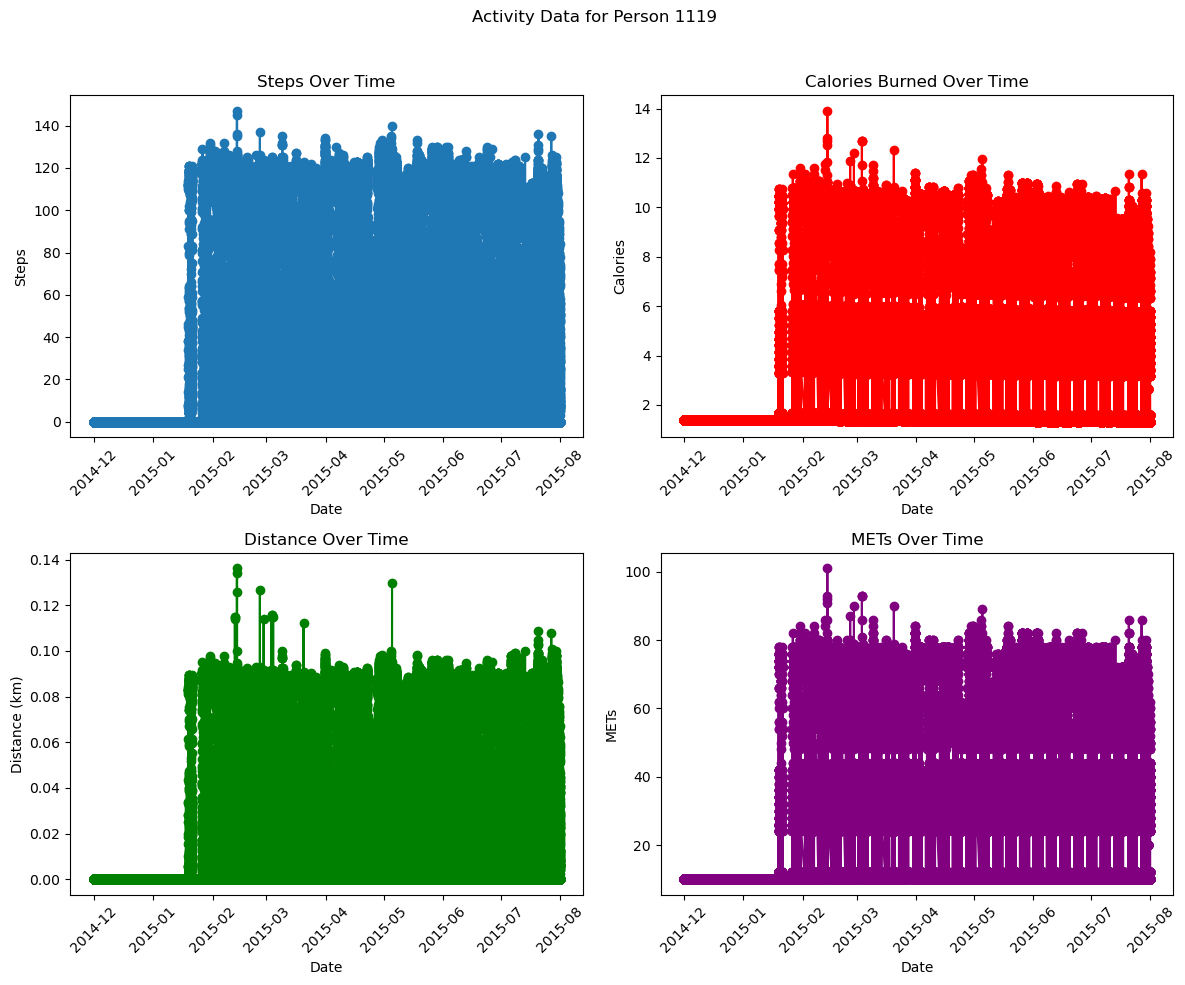

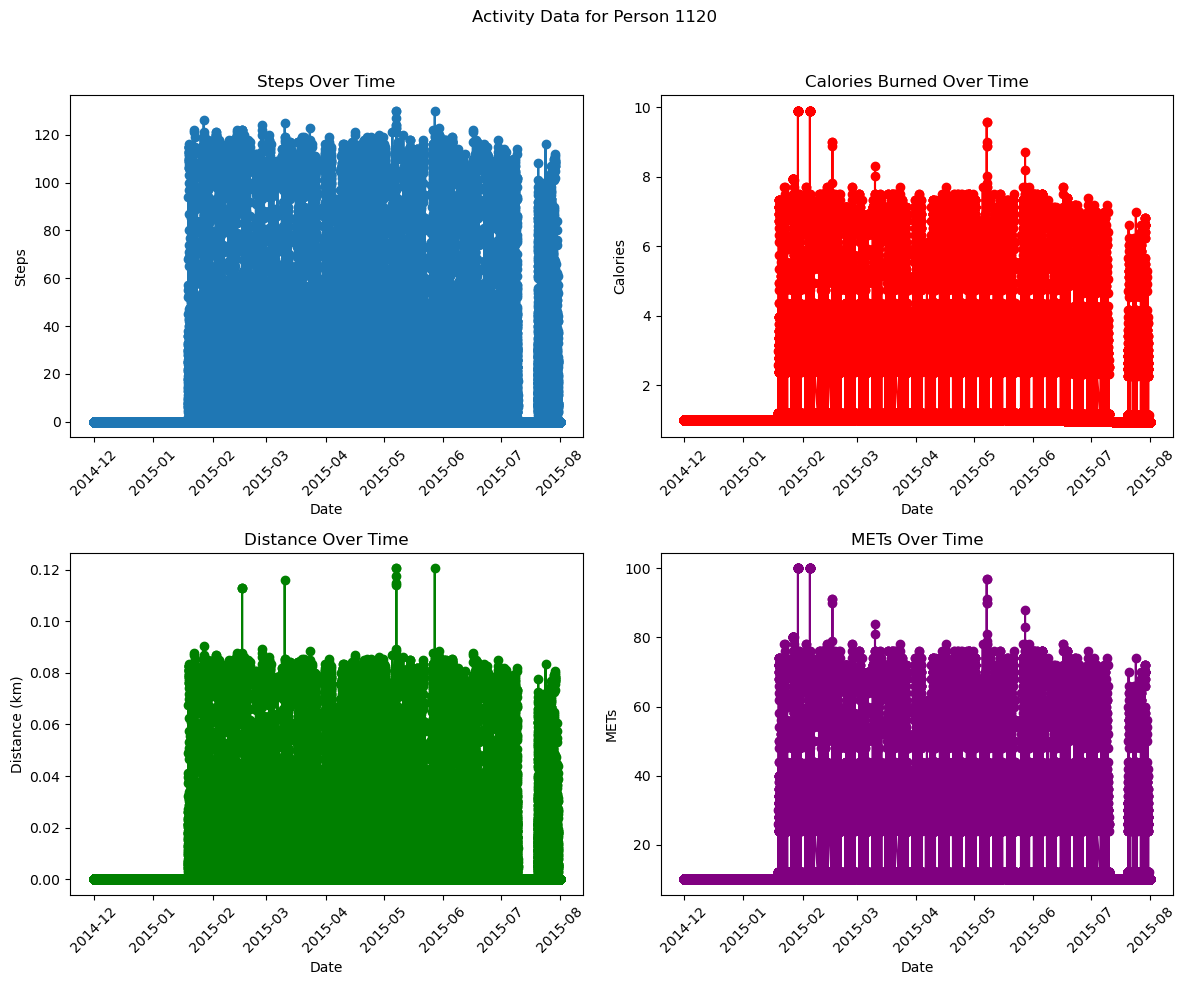

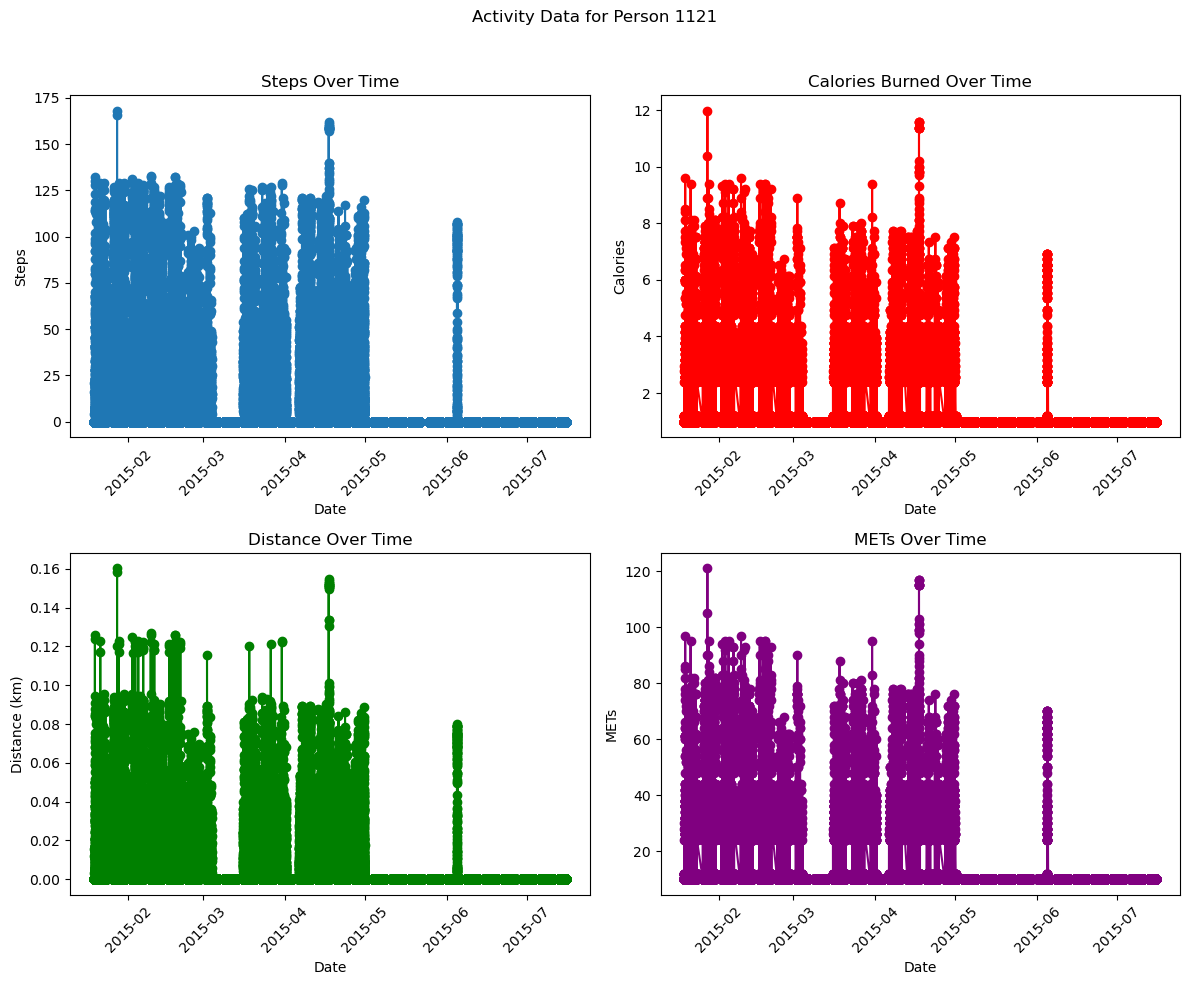

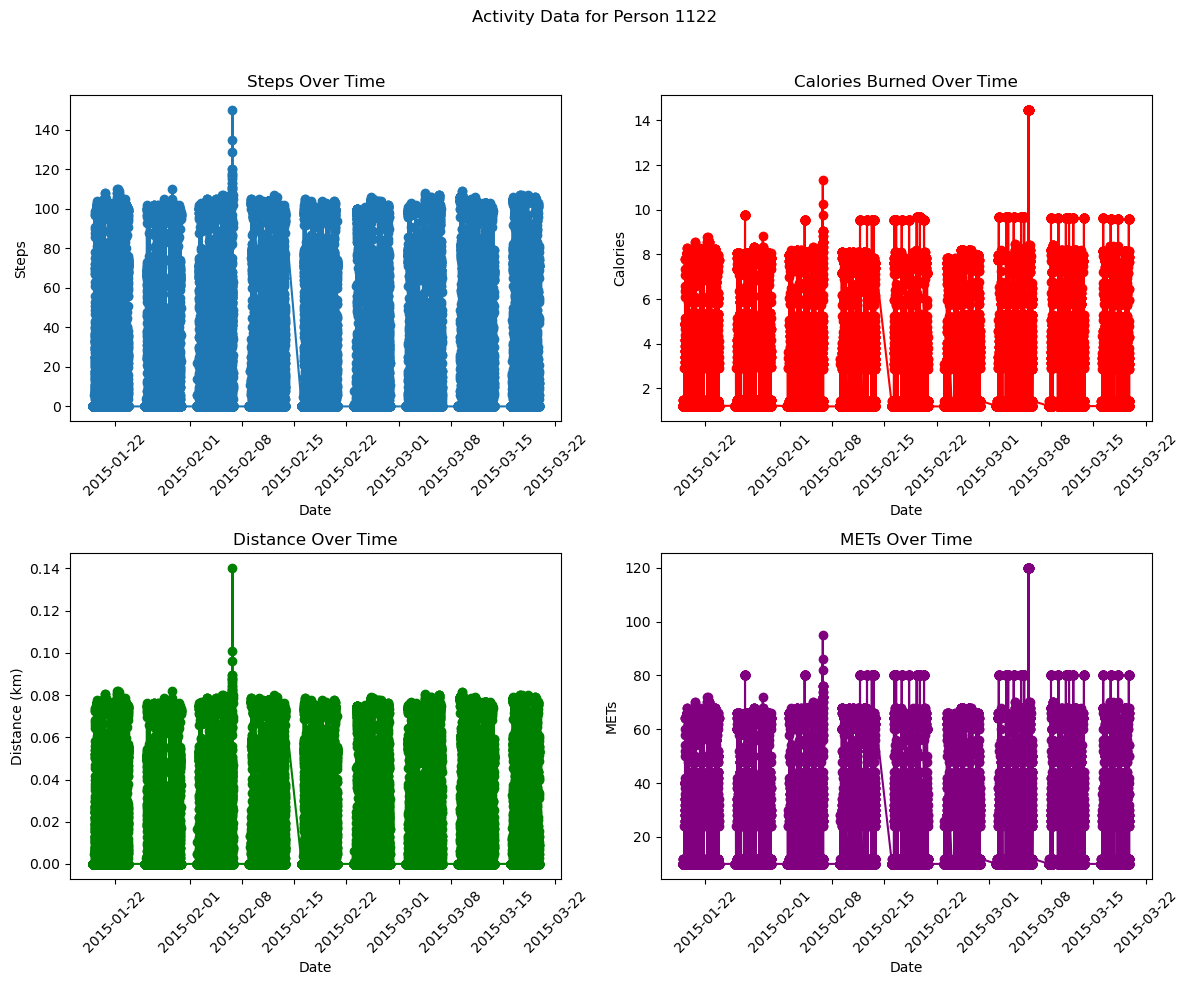

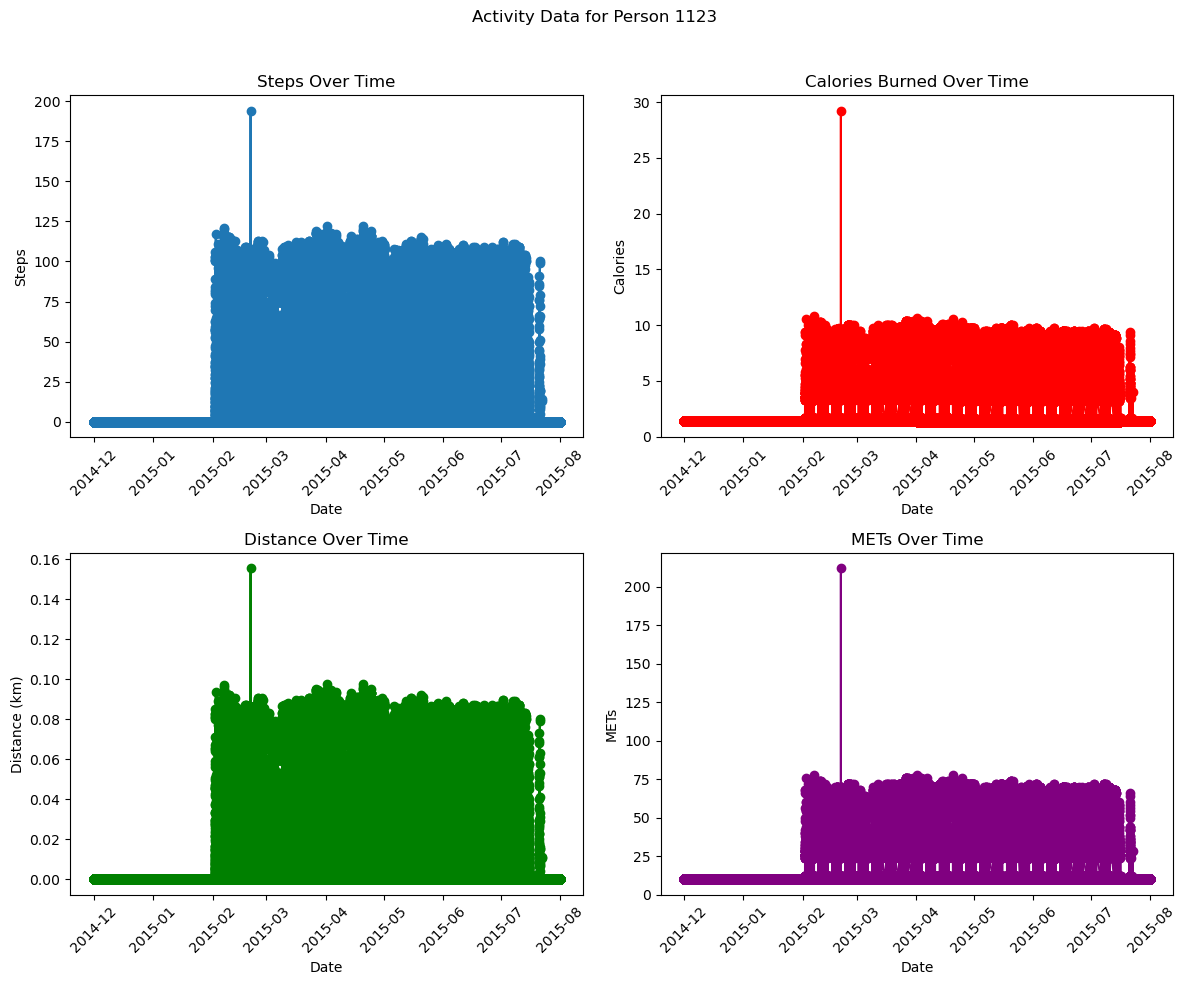

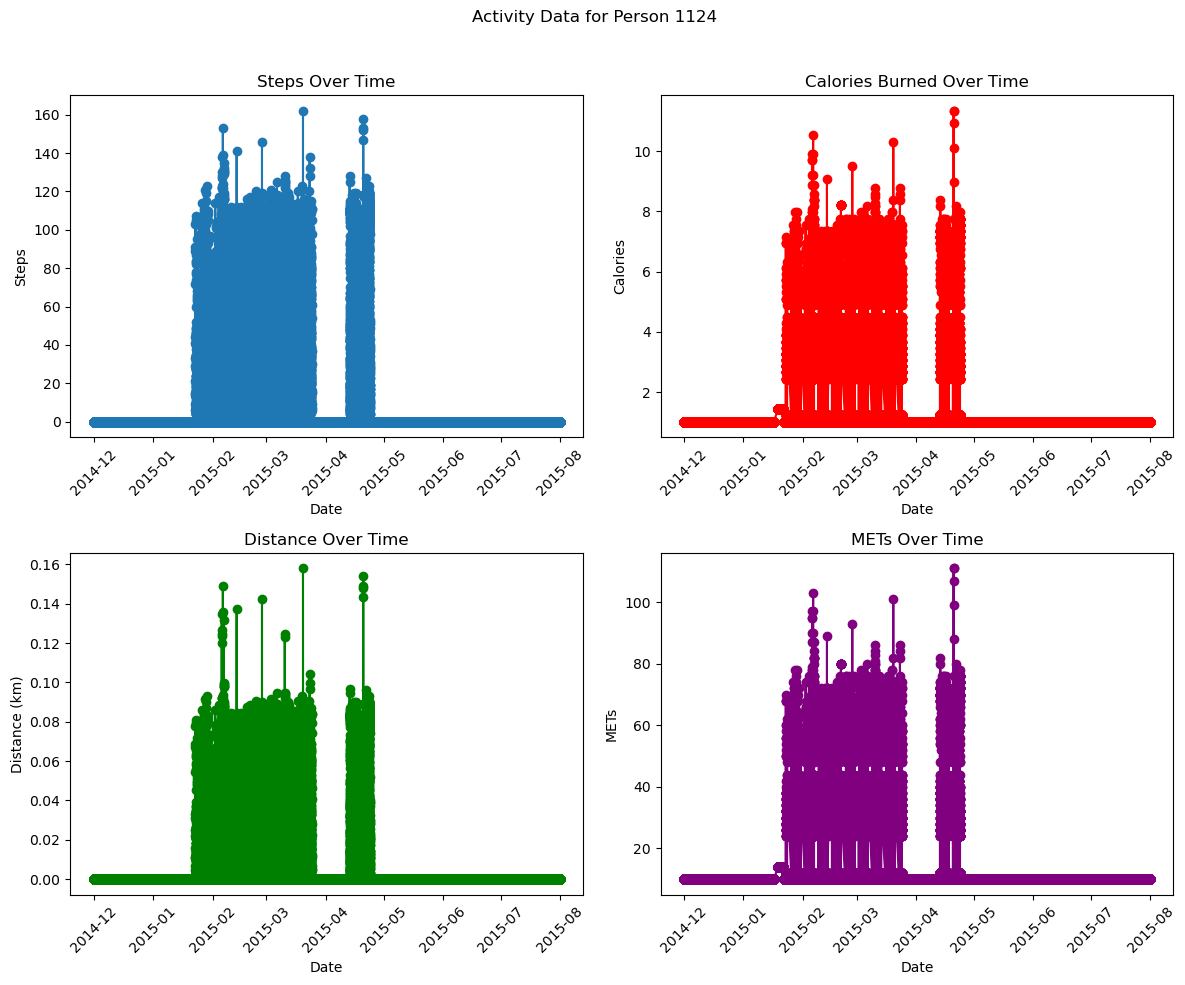

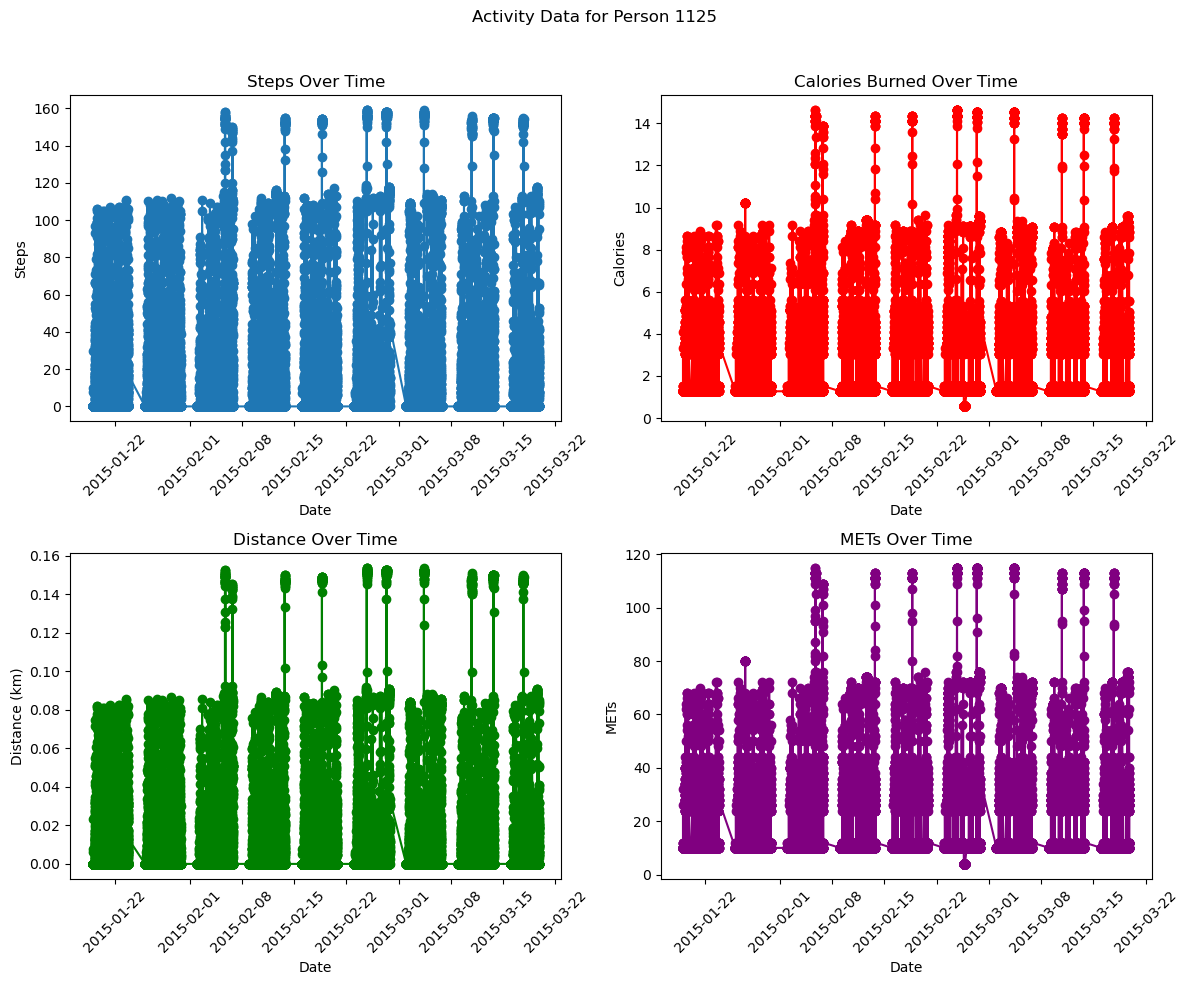

In [663]:
# Group by treatment_id and plot each person's data
for treatment_id, person_df in df.groupby("treatment_id"):
    plot_person_data(treatment_id, person_df)

### Plot 2: Comparison of Activity across individuals

In [664]:
def plot_group_comparison(df):
    # Préparation des données
    df_summary = df.groupby("treatment_id").agg({
        "steps": "mean",
        "calories": "mean",
        "distance": "mean",
        "mets": "mean"
    }).rename(columns={
        "steps": "Avg Steps",
        "calories": "Avg Calories",
        "distance": "Avg Distance",
        "mets": "Avg METs"
    })

    # Configuration des graphiques
    plot_config = [
        {'y': 'Avg Steps', 'type': 'bar', 'color': 'blue',
         'title': 'Average Steps', 'ylabel': 'Steps', 'xlabel': 'Person ID'},
        
        {'y': 'Avg Calories', 'type': 'bar', 'color': 'red',
         'title': 'Average Calories', 'ylabel': 'Calories', 'xlabel': 'Person ID'},
        
        {'y': 'Avg Distance', 'type': 'bar', 'color': 'green',
         'title': 'Average Distance', 'ylabel': 'Distance (km)', 'xlabel': 'Person ID'},
        
        {'y': 'Avg METs', 'type': 'bar', 'color': 'purple',
         'title': 'Average METs', 'ylabel': 'METs', 'xlabel': 'Person ID',
         'xticklabels': df_summary.index}
    ]

    # Appel à la fonction générique
    show_sub_plot(
        data=df_summary,
        plot_config=plot_config,
        title="Comparison of Activity Metrics Across Individuals",
        xticks_rotation=45,
        tight_layout=[0, 0, 1, 0.96],
        plot_type='bar'  # Valeur par défaut pour tous les graphiques
    )

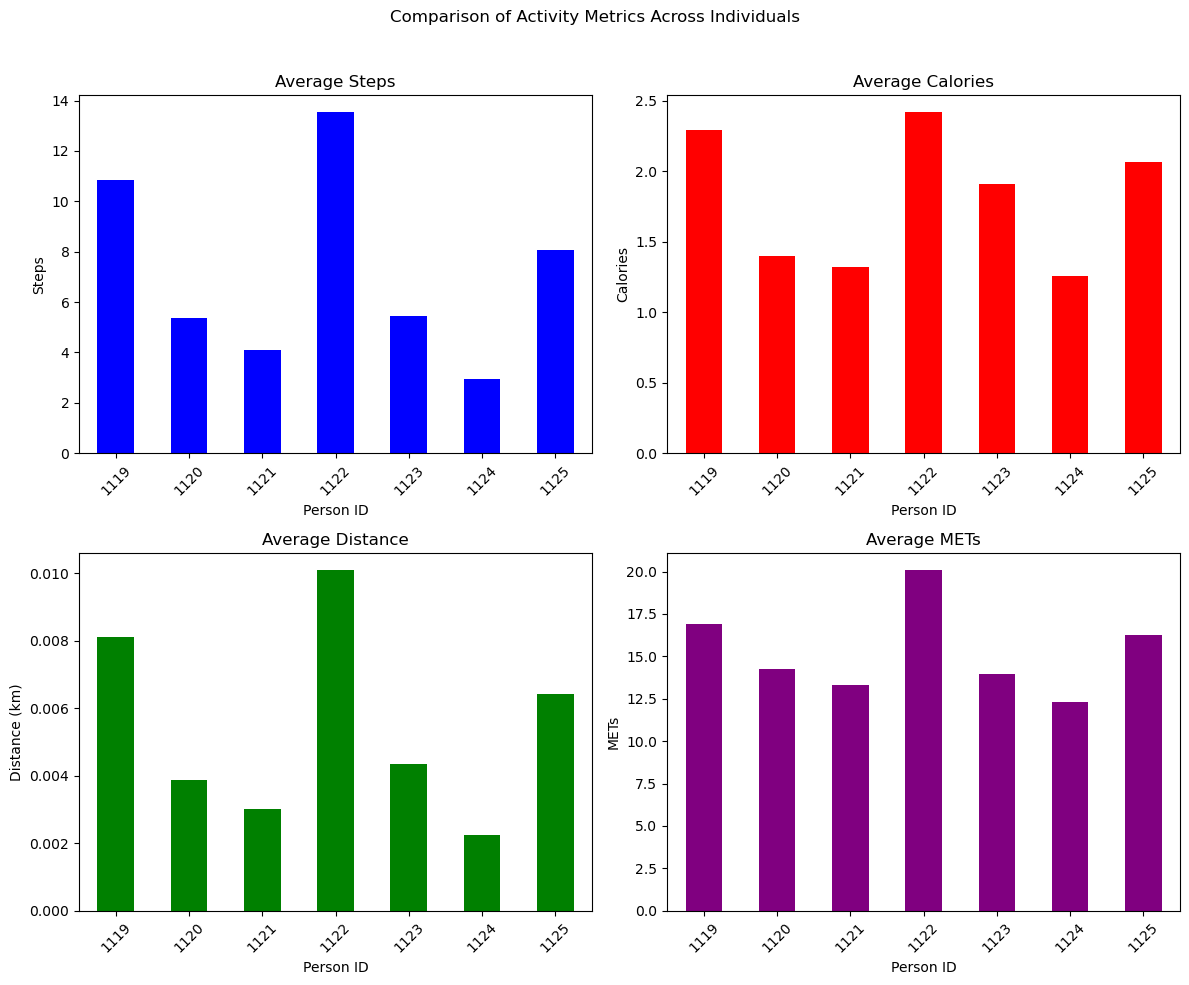

In [665]:
plot_group_comparison(df)

### Plot 3: Individual means

In [666]:
# Compute individual means for steps
individual_means = df.groupby(['treatment_id', df['date'].dt.date])['steps'].mean().reset_index()

In [667]:
# Convert 'date' back to datetime format
individual_means['date'] = pd.to_datetime(individual_means['date'])

In [668]:
treatment_ids = individual_means['treatment_id'].unique()

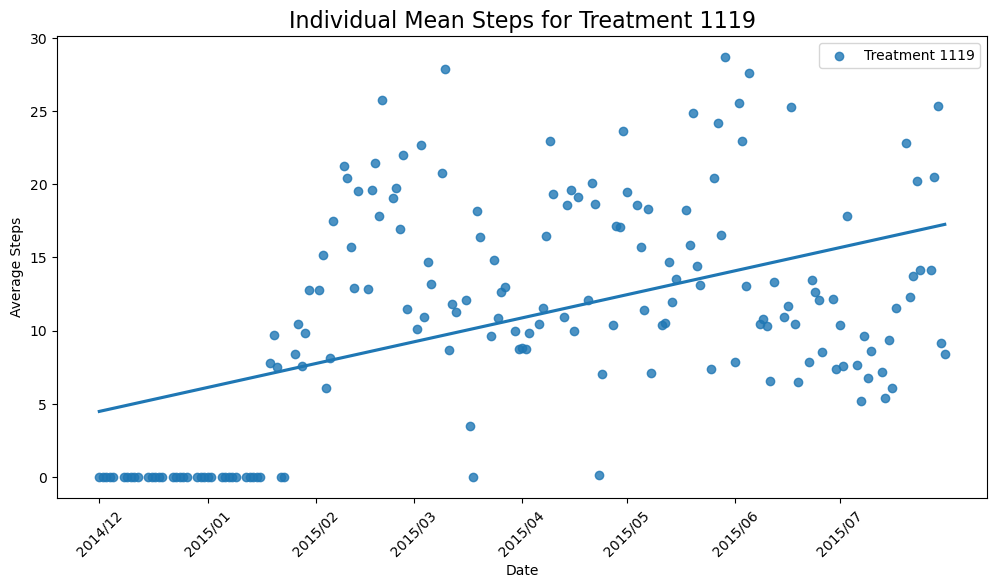

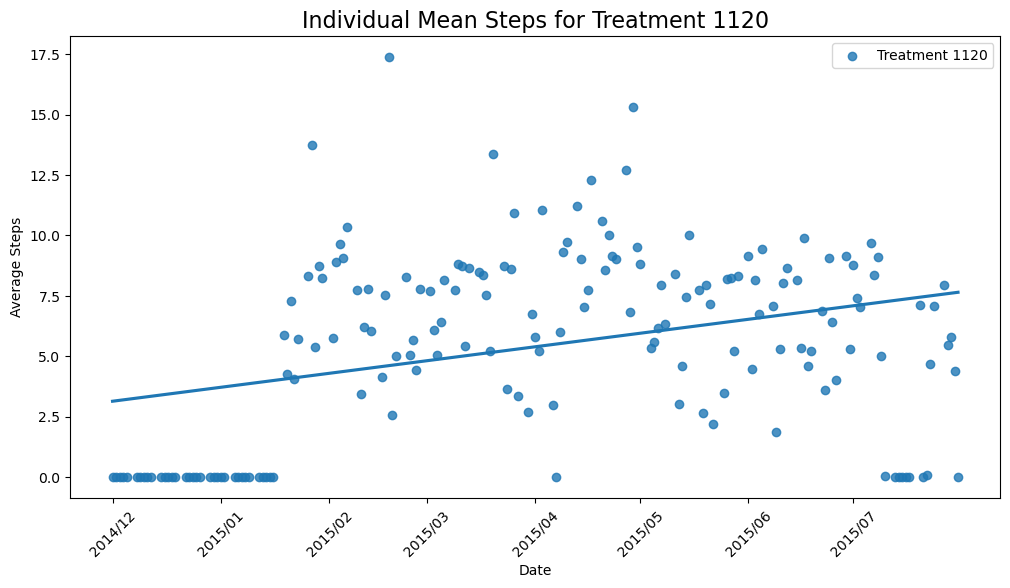

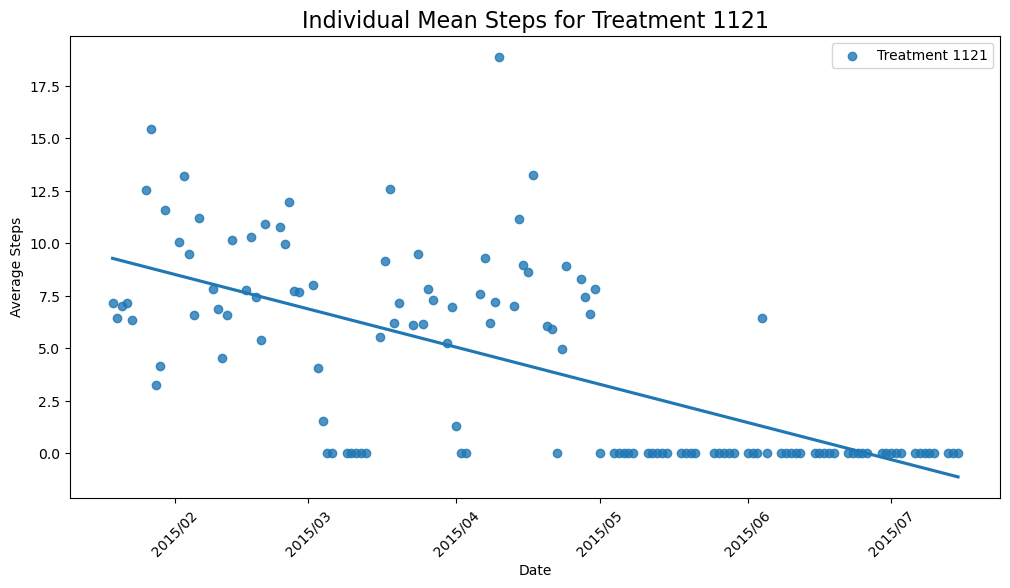

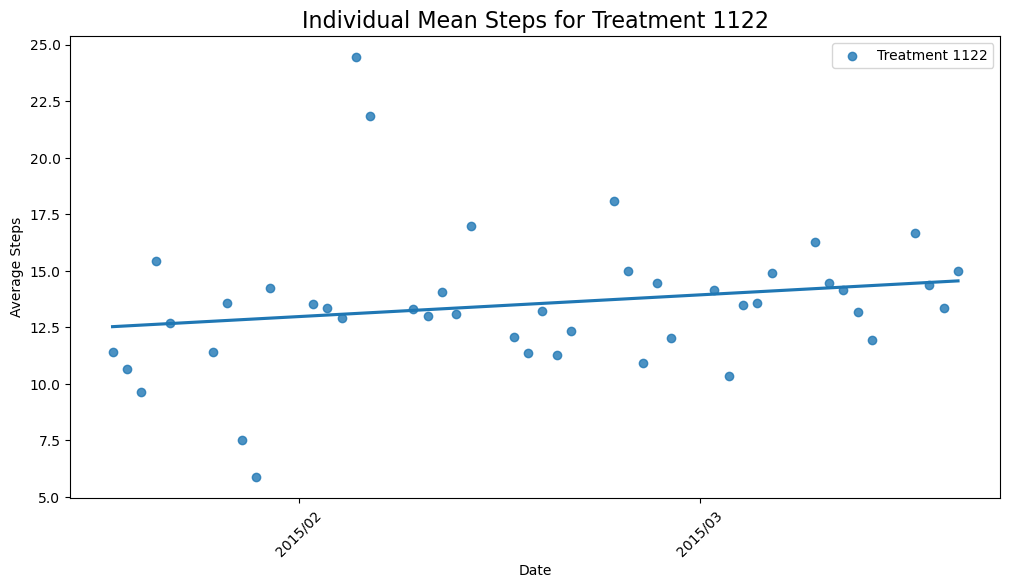

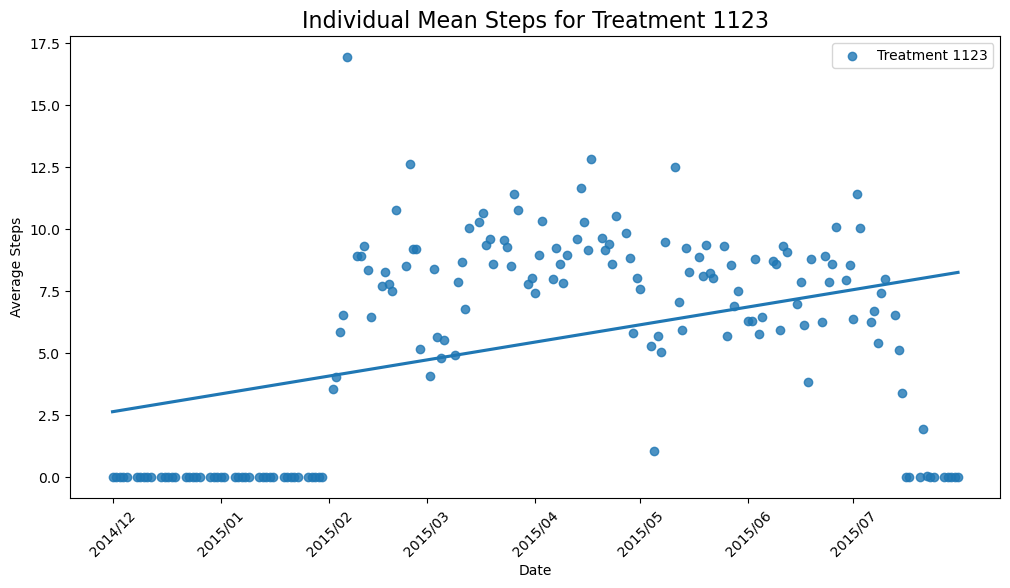

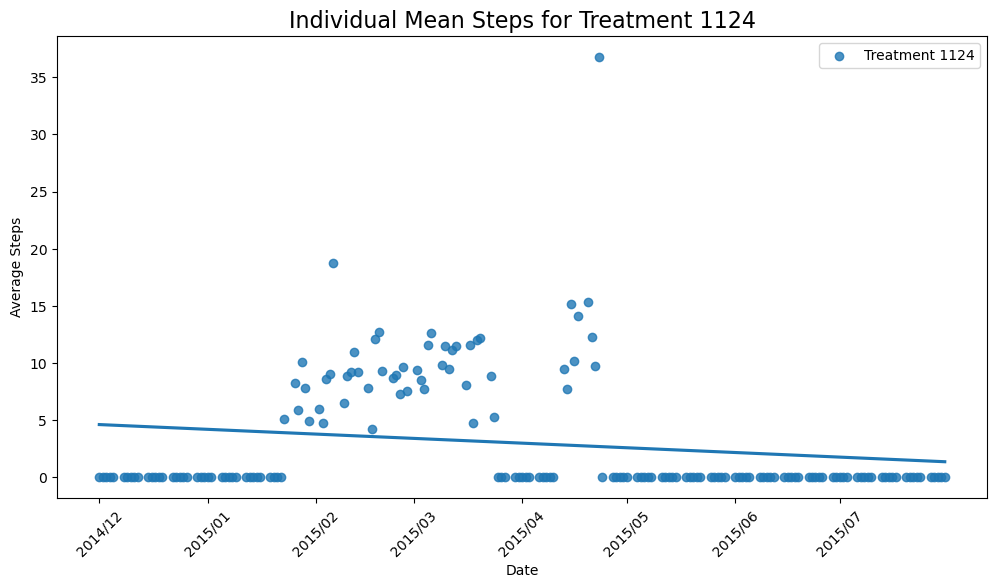

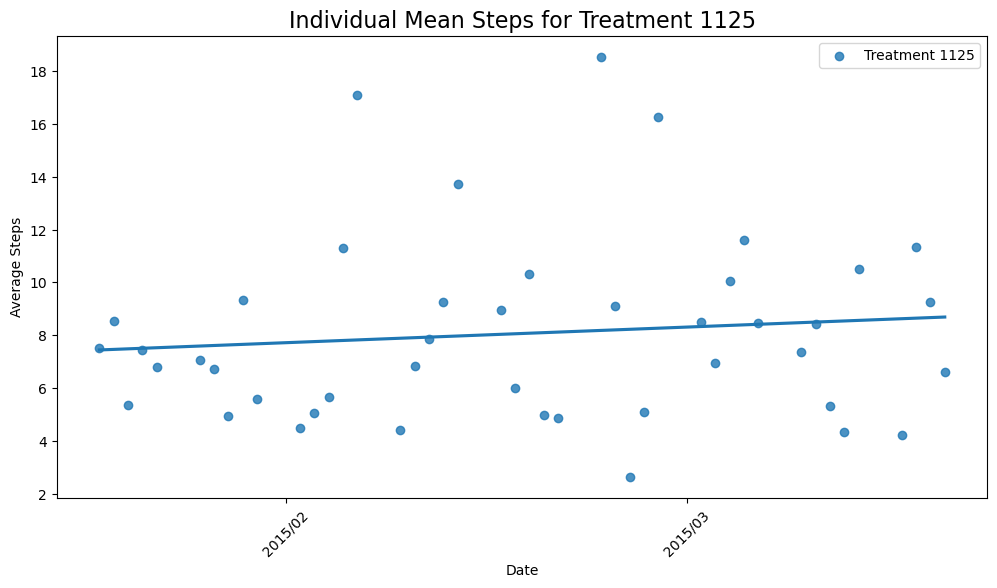

In [669]:
for treatment in treatment_ids:
    # Filter data for the current treatment_id
    subset = individual_means[individual_means['treatment_id'] == treatment].copy()

    # Convert 'date' to numeric for regression
    subset.loc[:, 'date_numeric'] = (subset['date'] - subset['date'].min()).dt.days

    # Prepare x-ticks (first day of each month)
    months = pd.date_range(start=subset['date'].min(), end=subset['date'].max(), freq='MS')
    month_numeric = (months - subset['date'].min()).days

    # Use show_plot function with modified label format
    show_plot(
        fig_size=(12, 6),
        reg_plot_data=subset,
        reg_plot_x='date_numeric',
        reg_plot_y='steps',
        reg_plot_scatter=True,
        reg_plot_ci=None,
        reg_plot_label=f'Treatment {treatment}',
        nbr_of_reg_plot=1,
        x_ticks_ticks=month_numeric,
        x_ticks_label=months.strftime('%Y/%m'),
        x_ticks_rotation=45,
        title=f"Individual Mean Steps for Treatment {treatment}",
        x_label="Date",
        y_label="Average Steps",
        legend=True
    )

### Plot 4: Average steps

In [670]:
# Compute the average of all individuals' steps per day
average_steps = df.groupby([df['date'].dt.date])['steps'].mean().reset_index()

In [671]:
# Convert 'date' back to datetime format
average_steps['date'] = pd.to_datetime(average_steps['date'])

In [672]:
# Calculate and print the average number of steps
overall_avg_steps = average_steps['steps'].mean()
print(f"Average number of steps: {overall_avg_steps:.2f} by minute")
print(f"Average number of steps: {overall_avg_steps * 60:.2f} by hour")
print(f"Average number of steps: {overall_avg_steps * 60 * 24:.2f} by day")

Average number of steps: 5.77 by minute
Average number of steps: 346.11 by hour
Average number of steps: 8306.60 by day


Average number of steps by minutes per person at 18:00 on a working day:
treatment_id
1119    10.864331
1120     5.387173
1121     4.116294
1122    13.529545
1123     5.436145
1124     2.957073
1125     8.067763
Name: steps, dtype: float64


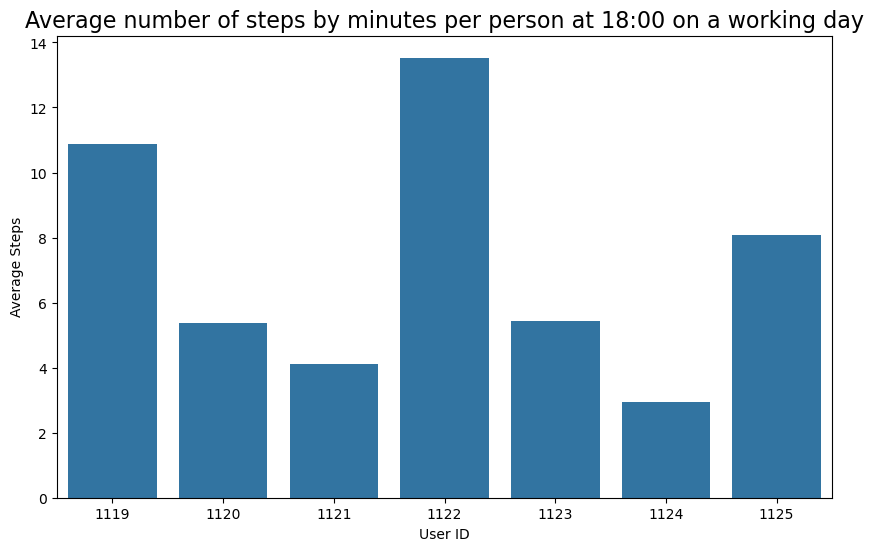

Average number of steps by hours per person at 18:00 on a working day:
treatment_id
1119    651.859850
1120    323.230376
1121    246.977621
1122    811.772727
1123    326.168722
1124    177.424361
1125    484.065789
Name: steps, dtype: float64


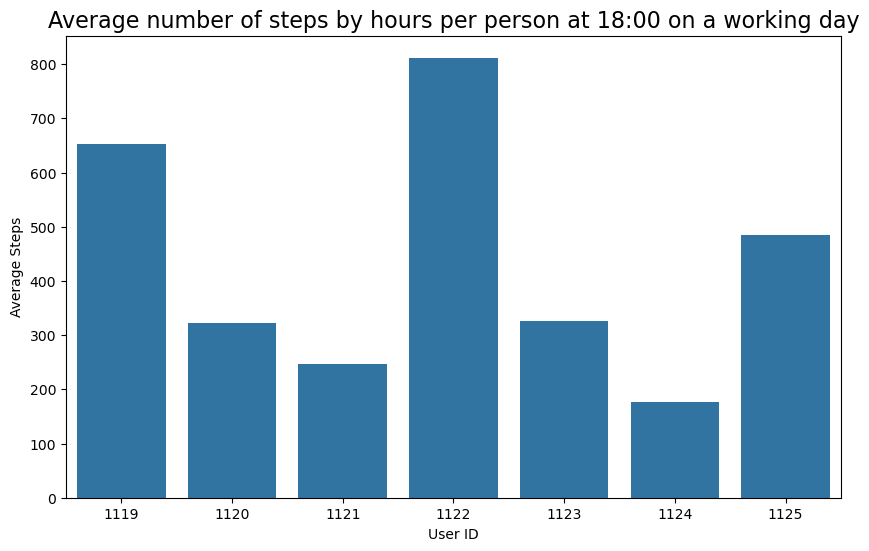

Average number of steps by day per person at 18:00 on a working day:
treatment_id
1119    15644.636391
1120     7757.529023
1121     5927.462909
1122    19482.545455
1123     7828.049323
1124     4258.184662
1125    11617.578947
Name: steps, dtype: float64


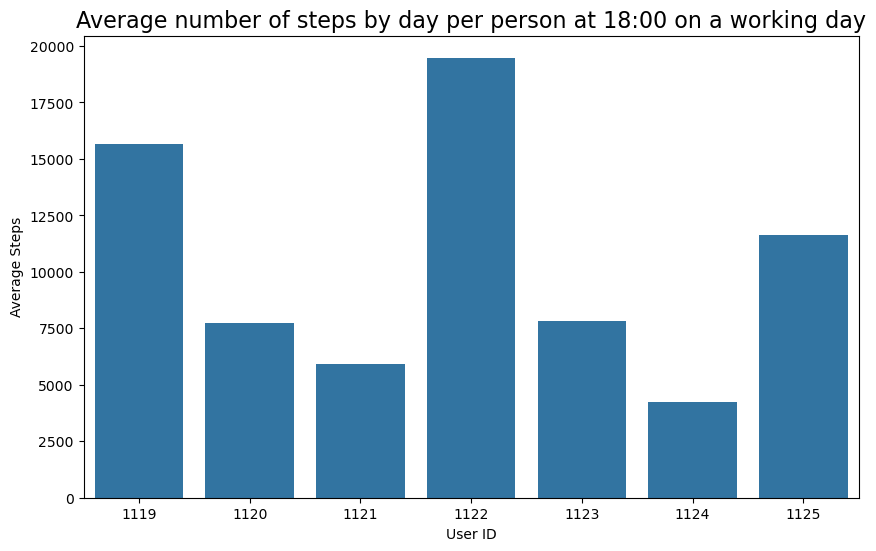

In [673]:
# Calculate the average number of steps per person at 18:00 on a working day
average_steps_per_person = df.groupby('treatment_id')['steps'].mean()
print("Average number of steps by minutes per person at 18:00 on a working day:")
print(average_steps_per_person)

# Plot average steps per user
show_plot(fig_size=(10, 6), title="Average number of steps by minutes per person at 18:00 on a working day",
        x_label="User ID", y_label="Average Steps", bar_plot_x=average_steps_per_person.index,
        bar_plot_y=average_steps_per_person.values)

In [ ]:
print("Average number of steps by hours per person at 18:00 on a working day:")
average_steps_per_person = average_steps_per_person * 60
print(average_steps_per_person)

show_plot(fig_size=(10, 6), title="Average number of steps by hours per person at 18:00 on a working day",
        x_label="User ID", y_label="Average Steps", bar_plot_x=average_steps_per_person.index,
        bar_plot_y=average_steps_per_person.values)

In [ ]:
average_steps_per_person = average_steps_per_person * 24
print("Average number of steps by day per person at 18:00 on a working day:")
print(average_steps_per_person)

show_plot(fig_size=(10, 6), title="Average number of steps by day per person at 18:00 on a working day",
        x_label="User ID", y_label="Average Steps", bar_plot_x=average_steps_per_person.index,
        bar_plot_y=average_steps_per_person.values)

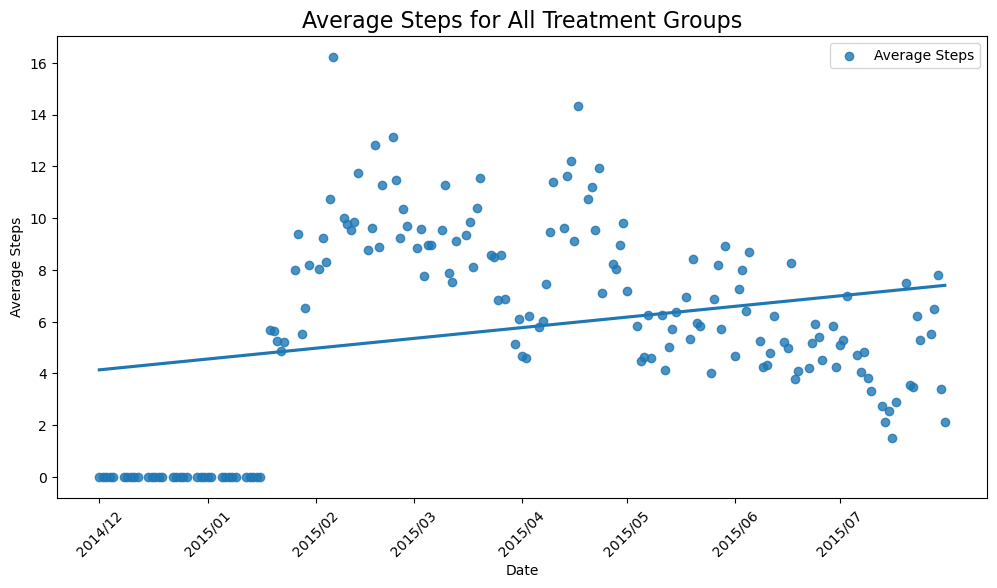

In [674]:
# Convert 'date' to numeric for regression
average_steps['date_numeric'] = (average_steps['date'] - average_steps['date'].min()).dt.days

# Prepare x-ticks (first day of each month)
months = pd.date_range(start=average_steps['date'].min(), end=average_steps['date'].max(), freq='MS')
month_numeric = (months - average_steps['date'].min()).days

# Use show_plot function with modified label format
show_plot(
    fig_size=(12, 6),
    reg_plot_data=average_steps,
    reg_plot_x='date_numeric',
    reg_plot_y='steps',
    reg_plot_scatter=True,
    reg_plot_ci=None,
    reg_plot_label='Average Steps',
    nbr_of_reg_plot=1,
    x_ticks_ticks=month_numeric,
    x_ticks_label=months.strftime('%Y/%m'),
    x_ticks_rotation=45,
    title="Average Steps for All Treatment Groups",
    x_label="Date",
    y_label="Average Steps",
    legend=True
)

### Plot 5: Individual plots with average steps superposed

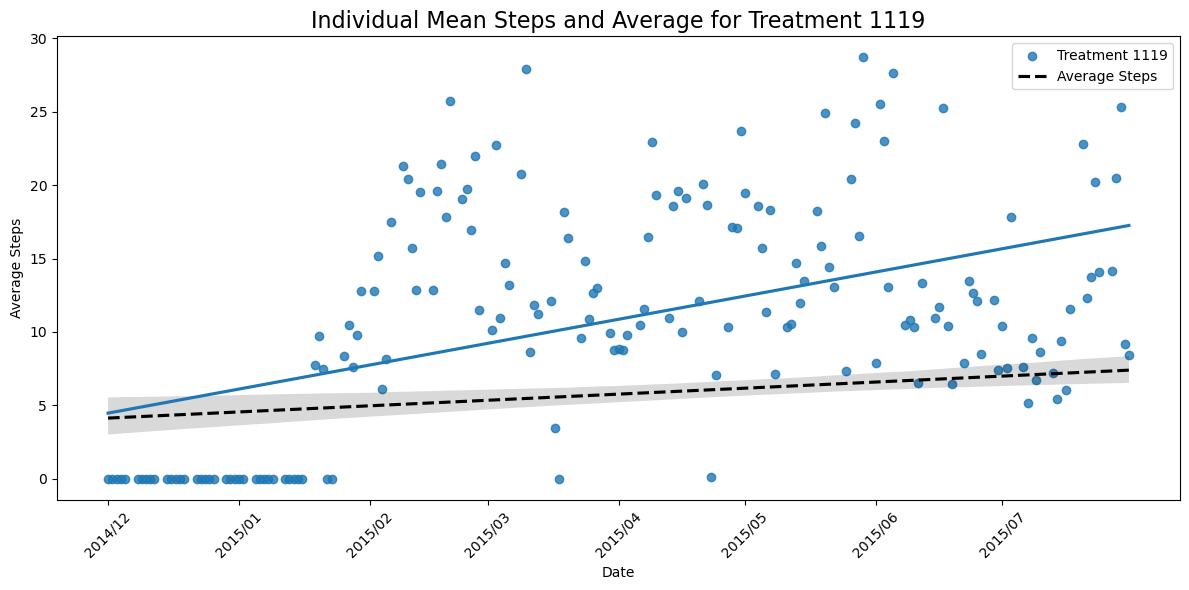

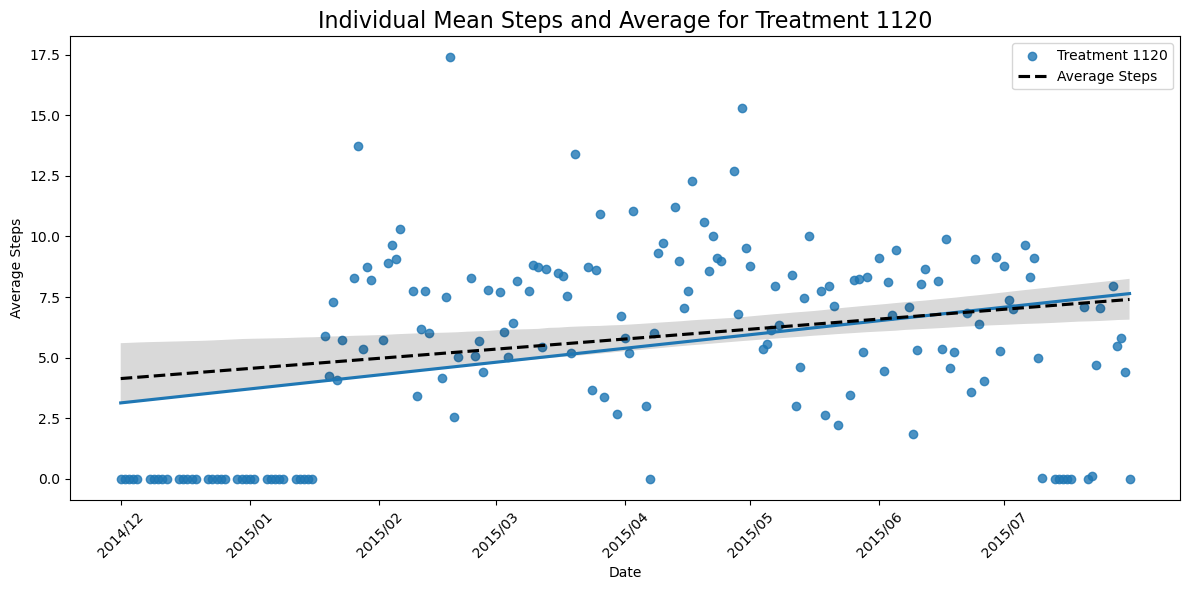

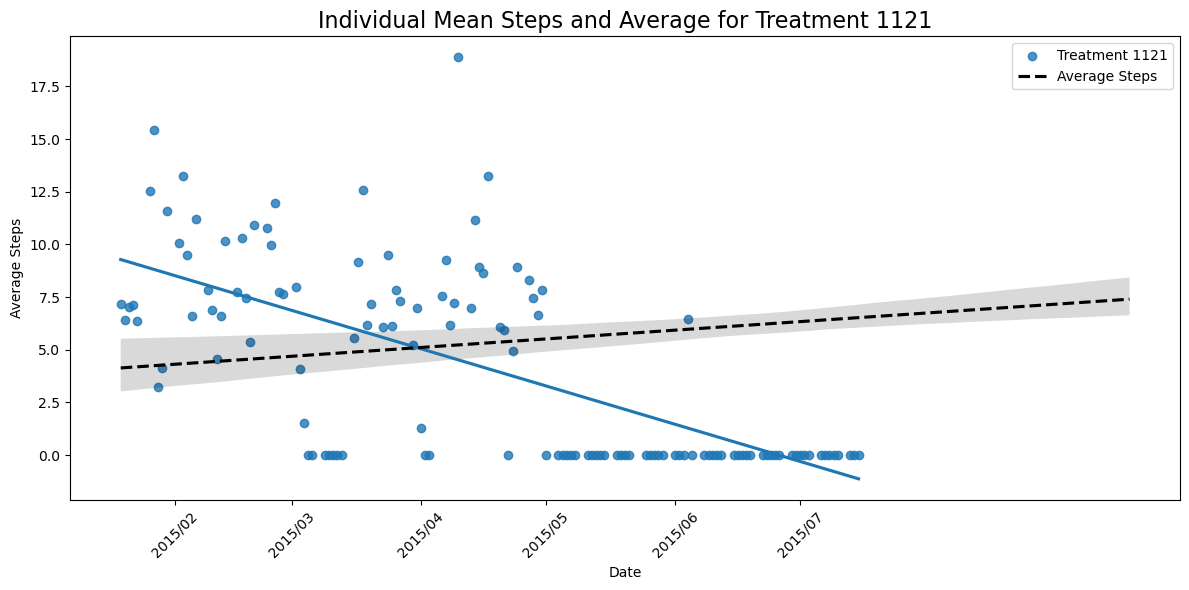

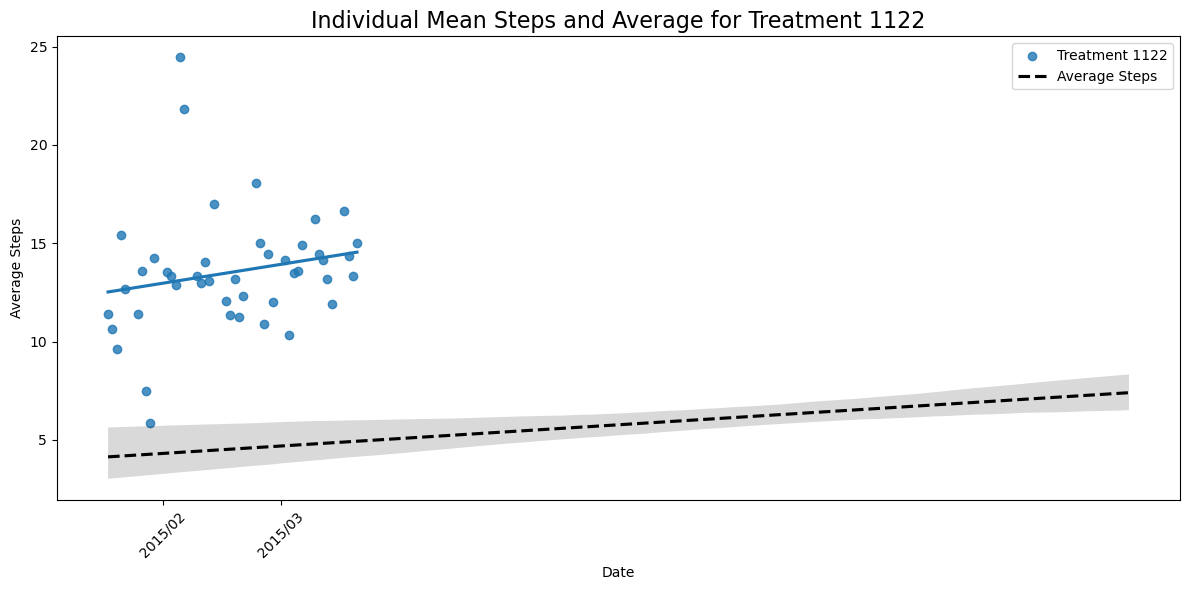

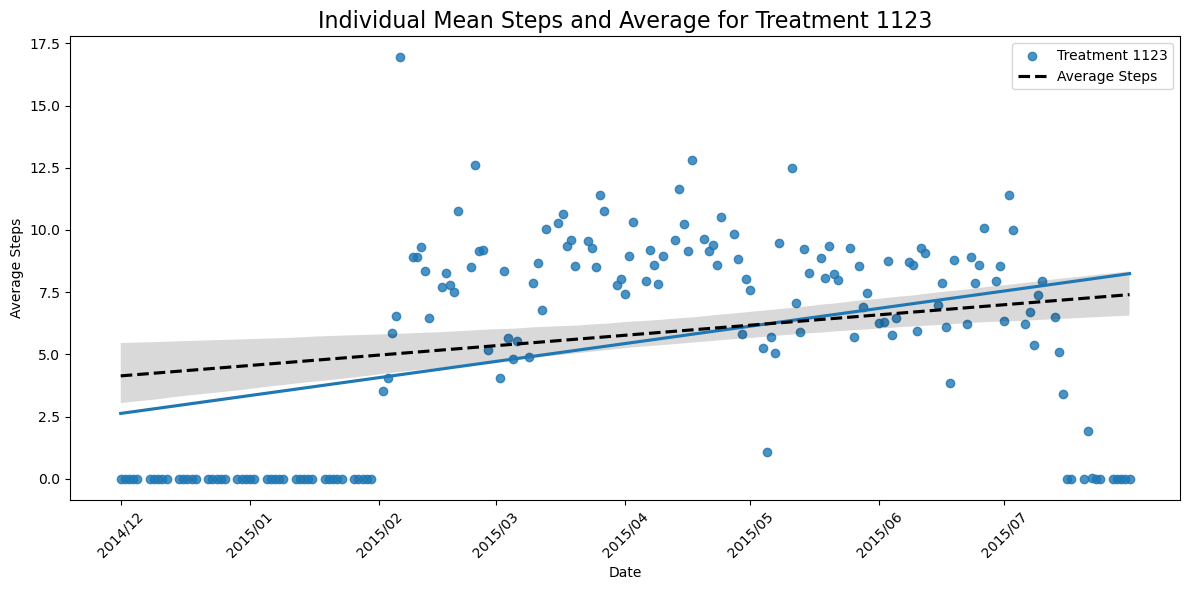

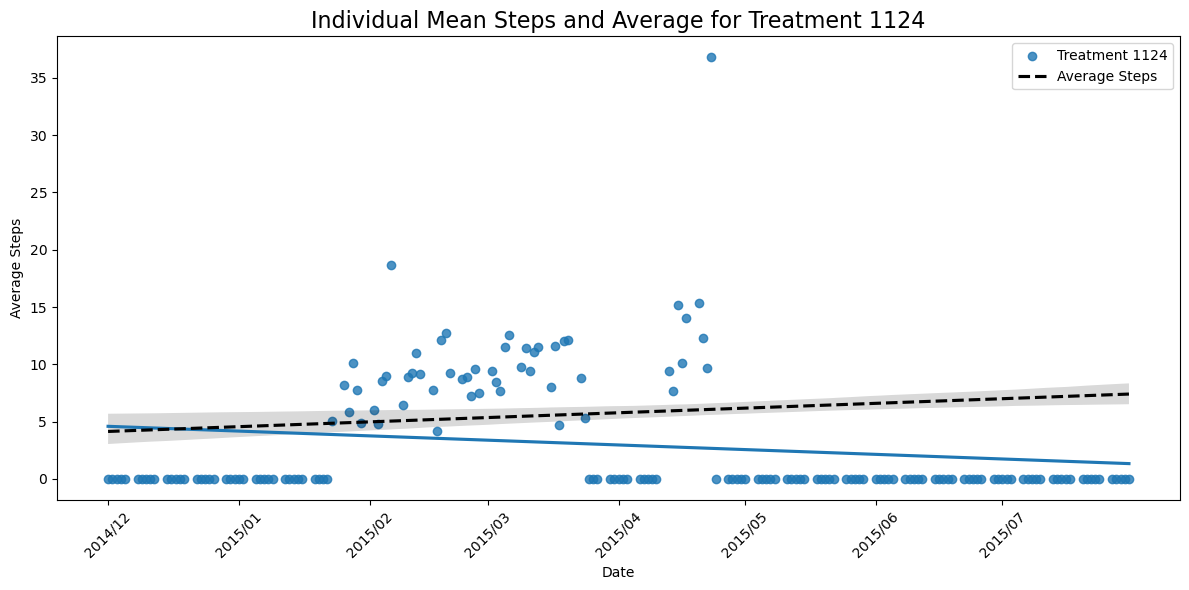

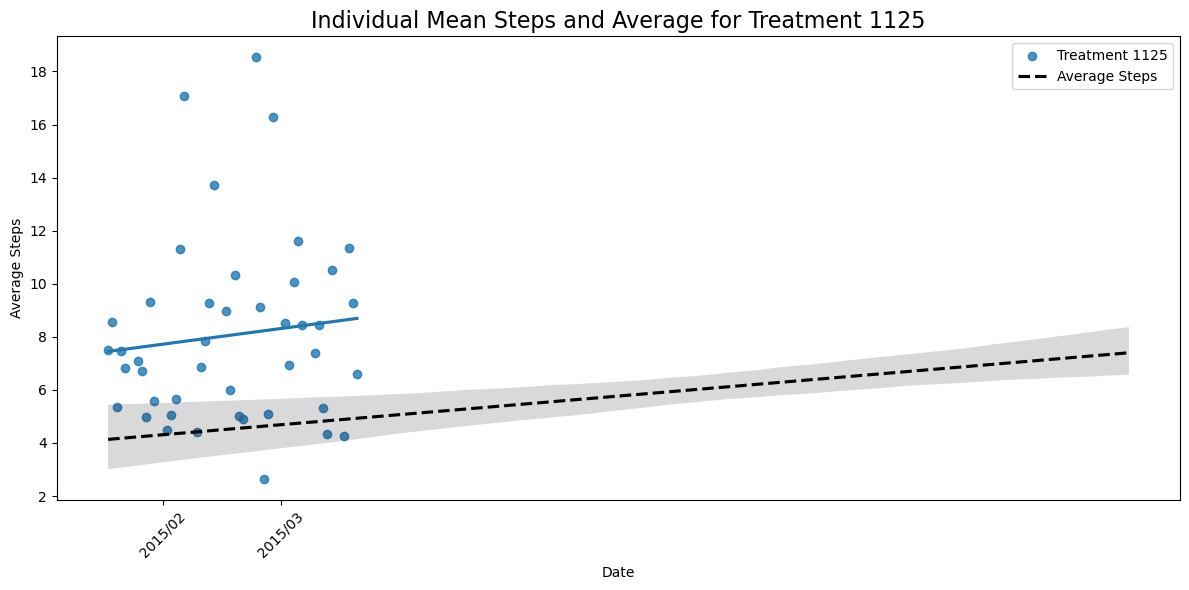

In [675]:
for treatment in treatment_ids:
    # Filter data for the current treatment_id
    subset = individual_means[individual_means['treatment_id'] == treatment].copy()
    
    # Convert 'date' to numeric for regression
    subset.loc[:, 'date_numeric'] = (subset['date'] - subset['date'].min()).dt.days
    
    # Prepare x-ticks (first day of each month)
    months = pd.date_range(start=subset['date'].min(), end=subset['date'].max(), freq='MS')
    month_numeric = (months - subset['date'].min()).days
    
    # Use show_plot function with both regressions
    show_plot(
        fig_size=(12, 6),
        reg_plot_data=[subset, average_steps],  # Liste des deux jeux de données
        reg_plot_x=['date_numeric', 'date_numeric'],  # Liste des deux variables x
        reg_plot_y=['steps', 'steps'],  # Liste des deux variables y
        reg_plot_scatter=[True, False],  # Scatter pour le 1er, ligne pour le 2nd
        reg_plot_ci=[None, 95],  # Pas d'intervalle de confiance pour les deux
        reg_plot_label=[
            f'Treatment {treatment}',  # Libellé avec tiret
            'Average Steps'           # Libellé avec tiret
        ],
        reg_plot_color=[None, 'black'],  # Couleur par défaut pour le 1er, noir pour le second
        reg_plot_line_kws=[
            None,  # Aucun style spécial pour la première régression
            {'color': 'black', 'linestyle': '--'}  # Style pour la moyenne
        ],
        nbr_of_reg_plot=2,  # Deux courbes de régression
        x_ticks_ticks=month_numeric,
        x_ticks_label=months.strftime('%Y/%m'),
        x_ticks_rotation=45,
        title=f"Individual Mean Steps and Average for Treatment {treatment}",
        x_label="Date",
        y_label="Average Steps",
        legend=True,
        tight_layout=[0, 0, 1, 1]  # Ajustement pour éviter les coupures
    )

### Plot 6: Superposed individuals and average steps

In [676]:
# Define a list of colors manually (you peux ajouter plus si nécessaire)
treatment_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [677]:
# Make sure there are enough colors for the number of treatment IDs
if len(treatment_ids) > len(treatment_colors):
    raise ValueError("Not enough colors for the number of treatment IDs!")

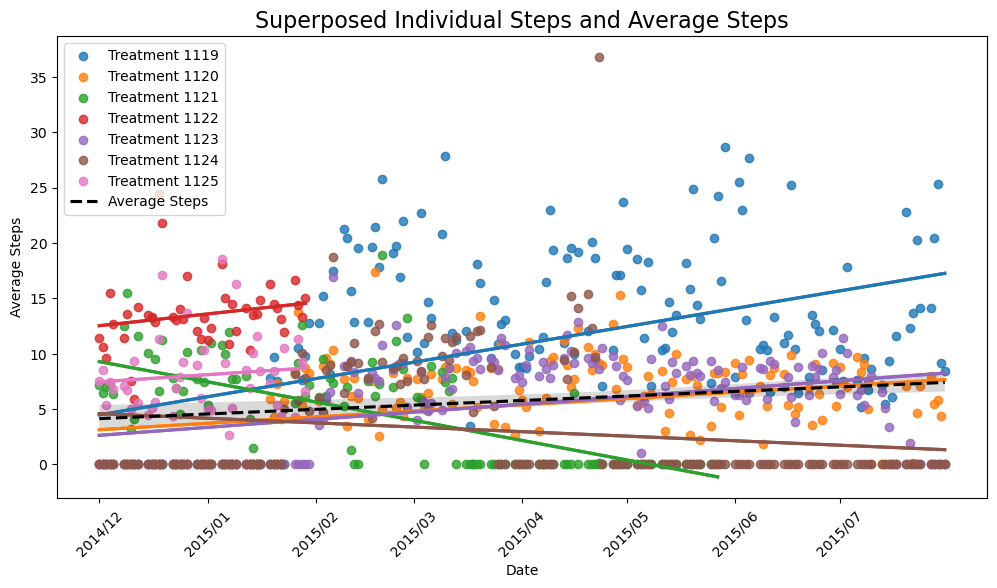

In [678]:
# Prepare common elements
months = pd.date_range(start=average_steps['date'].min(), end=average_steps['date'].max(), freq='MS')
month_numeric = (months - average_steps['date'].min()).days

# Prepare data for show_plot
reg_plot_data = []
reg_plot_x = []
reg_plot_y = []
reg_plot_scatter = []
reg_plot_ci = []
reg_plot_label = []
reg_plot_color = []
reg_plot_line_kws = []

# Loop through each treatment_id
for i, treatment in enumerate(treatment_ids):
    subset = individual_means[individual_means['treatment_id'] == treatment].copy()
    subset.loc[:, 'date_numeric'] = (subset['date'] - subset['date'].min()).dt.days

    # Add scatter plot parameters
    reg_plot_data.append(subset)
    reg_plot_x.append('date_numeric')
    reg_plot_y.append('steps')
    reg_plot_scatter.append(True)  # Show points
    reg_plot_ci.append(None)       # No confidence interval for scatter
    reg_plot_label.append(f'Treatment {treatment}')
    reg_plot_color.append(treatment_colors[i])
    reg_plot_line_kws.append(None)

    # Add regression line parameters
    reg_plot_data.append(subset)
    reg_plot_x.append('date_numeric')
    reg_plot_y.append('steps')
    reg_plot_scatter.append(False)  # Hide points (already shown)
    reg_plot_ci.append(None)        # No confidence interval
    reg_plot_label.append(None)     # No label (already in scatter)
    reg_plot_color.append(treatment_colors[i])
    reg_plot_line_kws.append(None)

# Add average steps line
reg_plot_data.append(average_steps)
reg_plot_x.append('date_numeric')
reg_plot_y.append('steps')
reg_plot_scatter.append(False)
reg_plot_ci.append(95)
reg_plot_label.append('Average Steps')
reg_plot_color.append('black')
reg_plot_line_kws.append({'color': 'black', 'linestyle': '--'})

# Calculate total number of plots (2 per treatment + 1 average)
nbr_of_reg_plot = len(treatment_ids) * 2 + 1

# Show the plot using your function
show_plot(
    fig_size=(12, 6),
    reg_plot_data=reg_plot_data,
    reg_plot_x=reg_plot_x,
    reg_plot_y=reg_plot_y,
    reg_plot_scatter=reg_plot_scatter,
    reg_plot_ci=reg_plot_ci,
    reg_plot_label=reg_plot_label,
    reg_plot_color=reg_plot_color,
    reg_plot_line_kws=reg_plot_line_kws,
    nbr_of_reg_plot=nbr_of_reg_plot,
    x_ticks_ticks=month_numeric,
    x_ticks_label=months.strftime('%Y/%m'),
    x_ticks_rotation=45,
    title="Superposed Individual Steps and Average Steps",
    x_label="Date",
    y_label="Average Steps",
    legend=True
)

### Plot 7: Correlation matrix

In [679]:
# Keep only numeric columns
df_numeric = df.select_dtypes(include=['number'])

In [680]:
# Compute correlation matrix
corr = df_numeric.corr()

In [681]:
# Remove columns that contain only NaN values
corr = corr.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [682]:
# Define a threshold for correlation values
threshold = 0.1

In [683]:
# Create a mask excluding the diagonal
mask = (corr.abs() < threshold).sum(axis=0) == (corr.shape[0] - 1)

In [684]:
# Get columns where all correlations (except diagonal) are below the threshold
low_correlation_cols = corr.columns[mask]

In [685]:
# Drop these columns and rows from the correlation matrix
corr = corr.drop(columns=low_correlation_cols, index=low_correlation_cols)

In [686]:
# Print correlation matrix as a table
print("Correlation Matrix:")
print(corr)

Correlation Matrix:
              treatment_id  fitbit_id  calories      mets     level     steps  \
treatment_id      1.000000   0.494536 -0.080300 -0.073930 -0.056890 -0.076463   
fitbit_id         0.494536   1.000000 -0.114261 -0.074379 -0.069105 -0.061600   
calories         -0.080300  -0.114261  1.000000  0.979681  0.932637  0.951678   
mets             -0.073930  -0.074379  0.979681  1.000000  0.956270  0.964365   
level            -0.056890  -0.069105  0.932637  0.956270  1.000000  0.906122   
steps            -0.076463  -0.061600  0.951678  0.964365  0.906122  1.000000   
distance         -0.068666  -0.061346  0.953724  0.963528  0.903404  0.998475   

              distance  
treatment_id -0.068666  
fitbit_id    -0.061346  
calories      0.953724  
mets          0.963528  
level         0.903404  
steps         0.998475  
distance      1.000000  


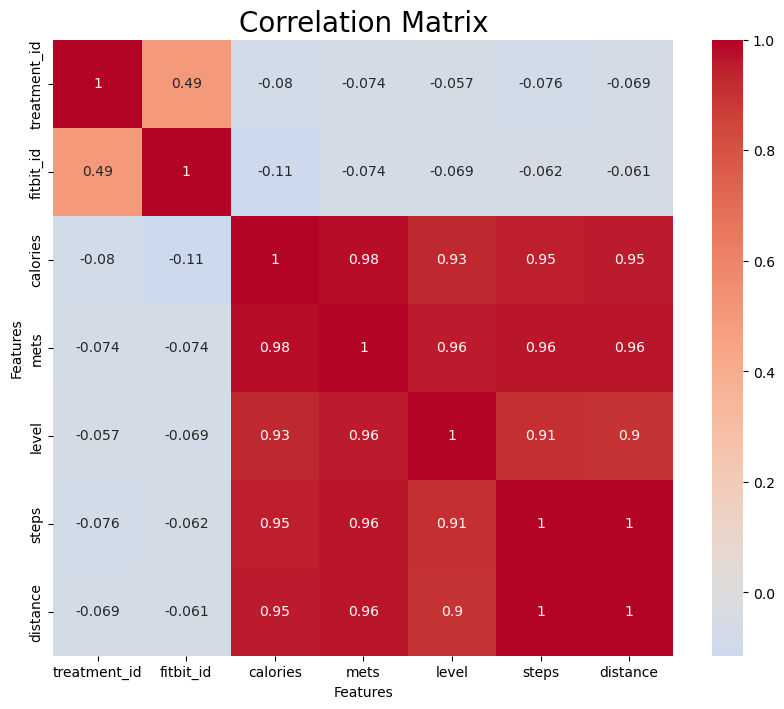

In [687]:
# Plot the correlation matrix
show_plot(fig_size=(10, 8), title="Correlation Matrix", x_label="Features",
        y_label="Features", heatmap_data=corr, heatmap_annot=True,
        heatmap_cmap='coolwarm', heatmap_center=0, tile_font_size=20)

### Plot 8: DAG graph

In [688]:
# Initialize a directed graph
dag = nx.DiGraph()

In [689]:
# Add nodes (dag_features)
dag_features = ['date', 'working_days', 'calories', 'mets', 'level', 'steps', 'distance', 'season']
dag.add_nodes_from(dag_features)

In [690]:
# Define the relationships based on correlation analysis
edges = [
    ('date', 'working_days'),
    ('date', 'season'),
    ('working_days', 'steps'),
    ('season', 'steps'),
    ('steps', 'calories'),
    ('steps', 'mets'),
    ('steps', 'level'),
    ('steps', 'distance'),
]

dag.add_edges_from(edges)

In [691]:
# Define custom positions for some nodes
pos = {
    'date': (0, 1),            # Position en haut pour 'date'
    'working_days': (-1, 0),   # Position à gauche pour 'working_days'
    'calories': (-1, -1),        # 'calories' au centre
    'mets': (0, -1),            # 'mets' à droite de 'calories'
    'season': (1, 0),          # 'level' en dessous de 'calories'
    'steps': (0, 0),          # 'steps' en dessous de 'mets'
    'distance': (-1, -2),        # 'distance' en bas de 'level'
    'level': (1, -2)        # 'distance' en bas de 'level'
}

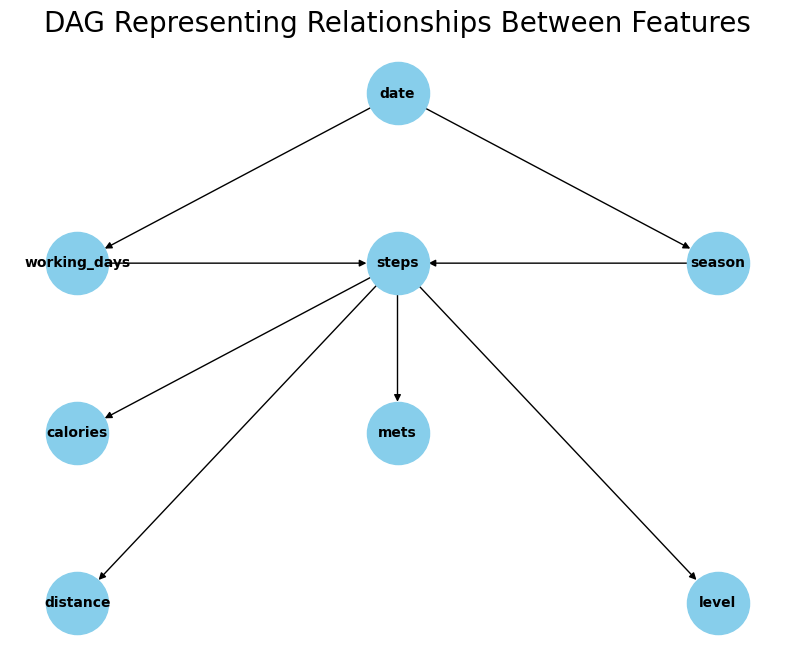

In [692]:
show_plot(fig_size=(10, 8), title="DAG Representing Relationships Between Features",
        tile_font_size=20, dag_graph=dag, dag_pos=pos,
        dag_with_labels=True, dag_node_size=2000, dag_node_color="skyblue",
        dag_node_font_size=10, dag_font_weight='bold', dag_edge_color='black')

## Step 2: Build a first version of the model

In [693]:
# Fonction pour déterminer la saison
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [694]:
# 1. Préparation des données
print("Preparing data...")
df['season'] = df['date'].apply(get_season)
df['hour'] = df['date'].dt.hour
df['is_weekend'] = df['date'].dt.weekday >= 5
df['cumulative_steps'] = df.groupby(['treatment_id', df['date'].dt.date])['steps'].cumsum()

Preparing data...


In [695]:
# 2. Création de la target (pour toutes les heures <= 18)
print("Creating target variable...")
df['target'] = 0
for user_id, user_avg in df[df['date'].dt.hour <= 18].groupby('treatment_id')['cumulative_steps'].mean().items():
    mask = (df['treatment_id'] == user_id) & (df['date'].dt.hour <= 18)  # Changement ici aussi
    df.loc[mask, 'target'] = (df.loc[mask, 'cumulative_steps'] >= user_avg).astype(int)

Creating target variable...


In [696]:
# 3. Création des variables one-hot pour les saisons
print("Creating season features...")
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    df[f'season_{season}'] = (df['season'] == season).astype(int)

Creating season features...


In [697]:
# 4. Définition des features
features = ['hour', 'is_weekend', 'cumulative_steps',
            'season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter']

In [698]:
# 5. Nettoyage des données
print("Cleaning data...")
# Supprimer les lignes avec NaN dans les features
df_clean = df.dropna(subset=features).copy()

Cleaning data...


In [699]:
# 6. Séparation train/test
print("Splitting data...")
train_users, test_users = train_test_split(df_clean['treatment_id'].unique(), test_size=0.3, random_state=42)
train_data = df_clean[df_clean['treatment_id'].isin(train_users)]
test_data = df_clean[df_clean['treatment_id'].isin(test_users)]

print("\nTreatment IDs for train users:", train_users)
print("Treatment IDs for test users:", test_users)

X_train = train_data[features]
y_train = train_data['target']
X_test = test_data[features]
y_test = test_data['target']

Splitting data...

Treatment IDs for train users: [1121 1123 1122 1125]
Treatment IDs for test users: [1119 1120 1124]


Training model...

Model Evaluation:
Accuracy: 0.97

Classification Report (sans accuracy):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    429729
           1       0.93      0.97      0.95    168771

   macro avg       0.96      0.97      0.96    598500
weighted avg       0.97      0.97      0.97    598500



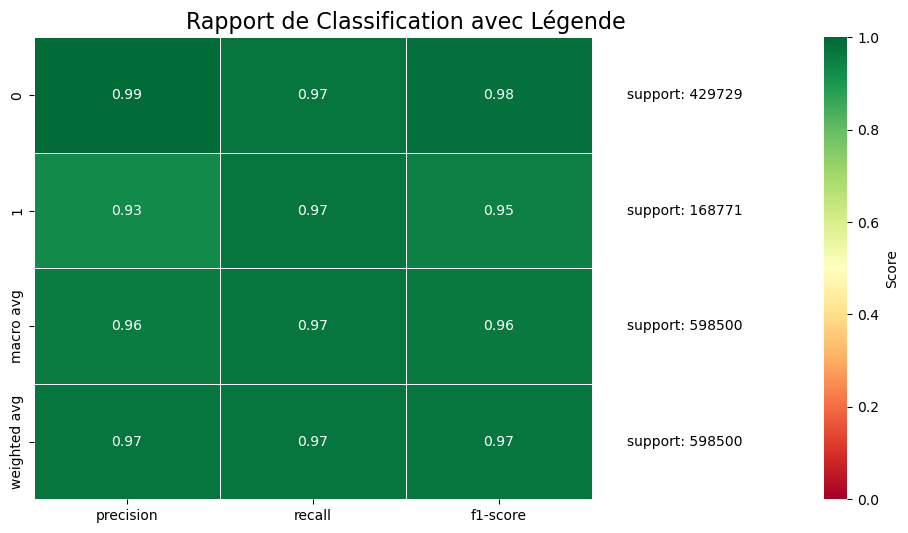

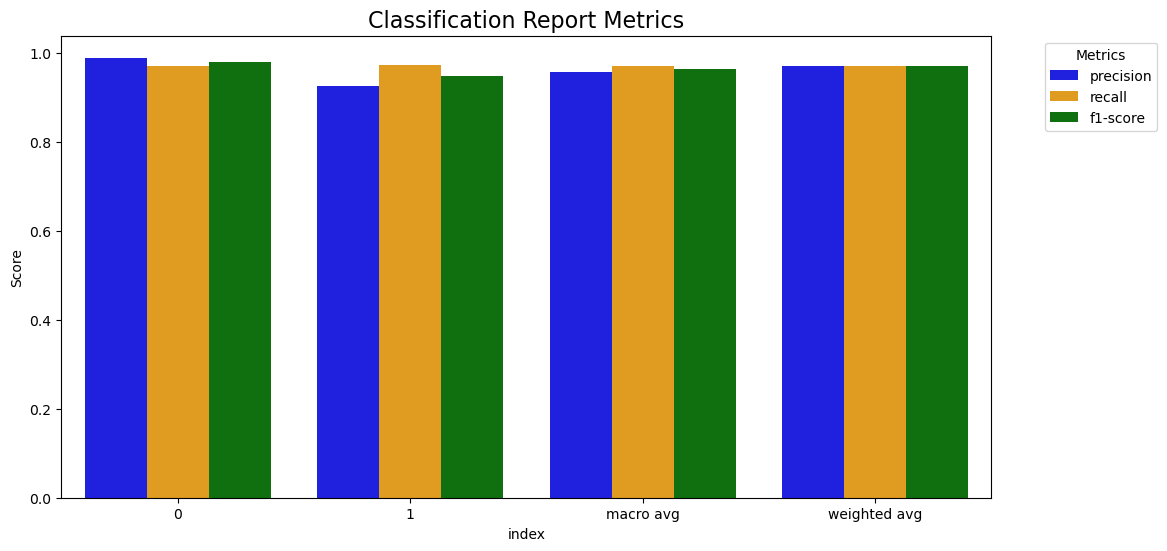

In [700]:
# 7. Entraînement du modèle avec SMOTE
print("Training model...")
try:
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    model = RandomForestClassifier(random_state=42, class_weight='balanced', 
                                 n_estimators=200, min_samples_leaf=5, max_depth=10)
    model.fit(X_res, y_res)
    
    # Évaluation
    y_pred = model.predict(X_test)
    print("\nModel Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    # Générer le rapport en dictionnaire
    report = classification_report(y_test, y_pred, output_dict=True)

    # Supprimer "accuracy"
    report.pop("accuracy", None)

    # Convertir le dictionnaire en texte sans "accuracy"
    report_text = classification_report(y_test, y_pred, output_dict=False)

    # Supprimer la ligne contenant "accuracy" dans la version texte
    report_text = "\n".join([line for line in report_text.split("\n") if "accuracy" not in line])

    # Affichage du rapport sans "accuracy"
    print("\nClassification Report (sans accuracy):")
    print(report_text)

    # Version heatmap
    show_plot(
        classification_report=report,
        cr_plot_type='heatmap',
        cr_cmap='RdYlGn',
        cr_show_colorbar=True,  # Affiche la légende colorée
        fig_size=(12, 6),
        title='Rapport de Classification avec Légende'
    )

    # Version barplot
    show_plot(
        classification_report=report,
        cr_plot_type='barplot',
        cr_palette={'precision': 'blue', 'recall': 'orange', 'f1-score': 'green'},
        fig_size=(12, 6),
        legend=True
    )

except ValueError as e:
    print(f"\nSMOTE Error: {e}")
    print("Using original imbalanced data (no SMOTE)")
    model = RandomForestClassifier(random_state=42, class_weight='balanced',
                                 n_estimators=200, min_samples_leaf=5, max_depth=10)
    model.fit(X_train, y_train)

In [701]:
# === PARTIE 1 : Votre code original ===
cm = confusion_matrix(y_test, y_pred)
print("\n" + "="*50)
print("MATRICE DE CONFUSION DÉTAILLÉE")
print("="*50)
print(f"Vrais Négatifs (Classe 0 correcte) : {cm[0,0]}")
print(f"Faux Positifs (Classe 0 prédite comme 1) : {cm[0,1]}")
print(f"Faux Négatifs (Classe 1 prédite comme 0) : {cm[1,0]}")
print(f"Vrais Positifs (Classe 1 correcte) : {cm[1,1]}")
print("\nRésumé :")
print(f"Erreurs totales : {cm[0,1] + cm[1,0]} ({(cm[0,1] + cm[1,0])/cm.sum()*100:.2f}% des cas)")
print("="*50 + "\n")


MATRICE DE CONFUSION DÉTAILLÉE
Vrais Négatifs (Classe 0 correcte) : 416639
Faux Positifs (Classe 0 prédite comme 1) : 13090
Faux Négatifs (Classe 1 prédite comme 0) : 4706
Vrais Positifs (Classe 1 correcte) : 164065

Résumé :
Erreurs totales : 17796 (2.97% des cas)



In [702]:
# === PARTIE 2 : Amélioration 1 - Métriques avancées ===
print("\n" + "="*50)
print("RAPPORT DE CLASSIFICATION COMPLET")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Classe 0', 'Classe 1']))

# Calculs supplémentaires
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
print(f"\nDétails par classe:")
print(f"Précision - Classe 0: {precision[0]:.3f}, Classe 1: {precision[1]:.3f}")
print(f"Rappel    - Classe 0: {recall[0]:.3f}, Classe 1: {recall[1]:.3f}")
print(f"F1-score  - Classe 0: {f1[0]:.3f}, Classe 1: {f1[1]:.3f}")


RAPPORT DE CLASSIFICATION COMPLET
              precision    recall  f1-score   support

    Classe 0       0.99      0.97      0.98    429729
    Classe 1       0.93      0.97      0.95    168771

    accuracy                           0.97    598500
   macro avg       0.96      0.97      0.96    598500
weighted avg       0.97      0.97      0.97    598500


Détails par classe:
Précision - Classe 0: 0.989, Classe 1: 0.926
Rappel    - Classe 0: 0.970, Classe 1: 0.972
F1-score  - Classe 0: 0.979, Classe 1: 0.949


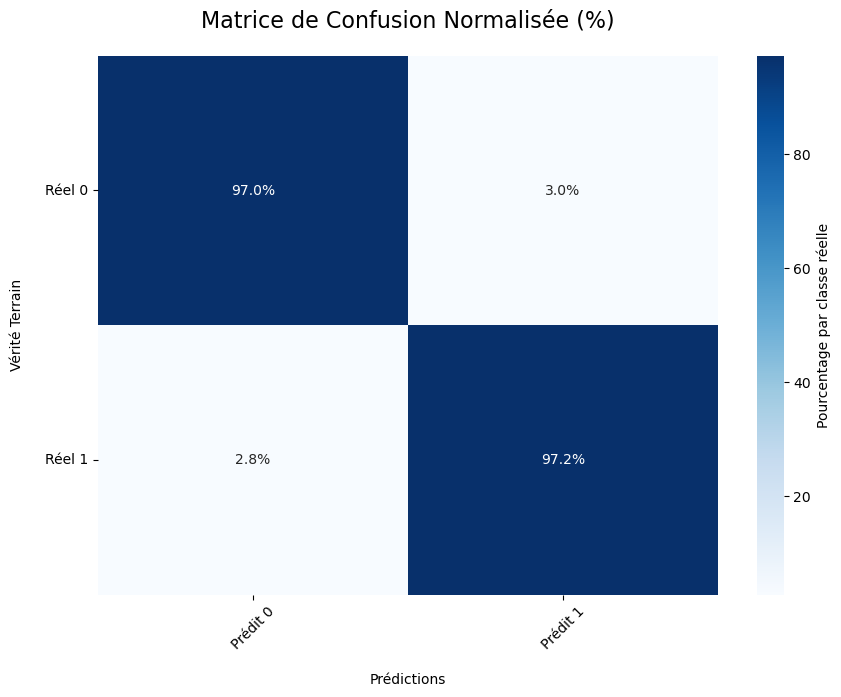

In [703]:
# === PARTIE 3 : Amélioration 2 - Visualisation normalisée ===
# === CORRECTION : Partie Visualisation Normalisée ===
plt.figure(figsize=(10, 7))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Conversion en pourcentage

# Modification ici : '.1f' au lieu de '.1f%' + ajout du symbole % dans les annotations
annot_labels = np.array([f"{val:.1f}%" for val in cm_normalized.flatten()]).reshape(cm_normalized.shape)

sns.heatmap(cm_normalized, annot=annot_labels, fmt='', cmap='Blues',  # fmt='' car nos labels sont pré-formatés
            xticklabels=['Prédit 0', 'Prédit 1'], 
            yticklabels=['Réel 0', 'Réel 1'],
            cbar_kws={'label': 'Pourcentage par classe réelle'})

plt.title('Matrice de Confusion Normalisée (%)', pad=20, fontsize=16)
plt.xlabel('Prédictions', labelpad=15)
plt.ylabel('Vérité Terrain', labelpad=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

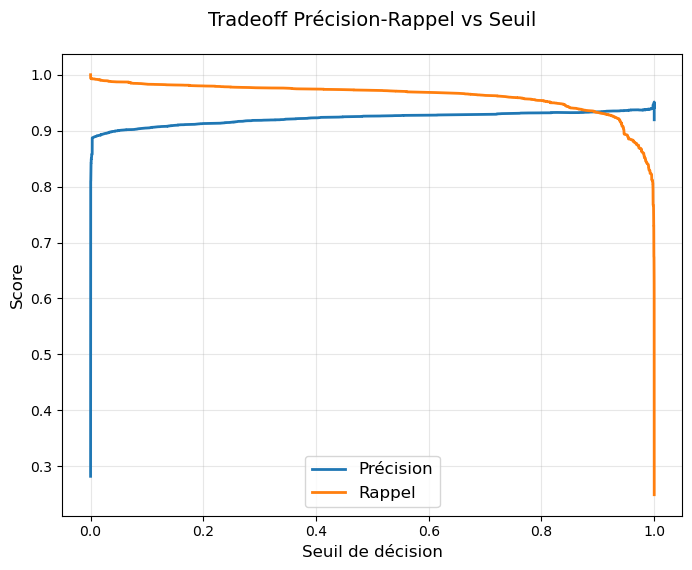

In [704]:
# === PARTIE 4 : Amélioration 3 - Seuil de décision (si modèle probabiliste) ===
if hasattr(model, "predict_proba"):
    y_probs = model.predict_proba(X_test)[:, 1]
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision_curve[:-1], label="Précision", linewidth=2)
    plt.plot(thresholds, recall_curve[:-1], label="Rappel", linewidth=2)
    plt.xlabel("Seuil de décision", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend(fontsize=12)
    plt.title("Tradeoff Précision-Rappel vs Seuil", pad=20, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

In [705]:
# === PARTIE 5 : Amélioration 4 - Analyse des erreurs ===
fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]  # Faux positifs
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]  # Faux négatifs

print("\n" + "="*50)
print("ANALYSE DES ERREURS")
print("="*50)
print(f"Faux positifs (FP): {len(fp_indices)} cas ({len(fp_indices)/len(y_test)*100:.1f}%)")
print(f"Faux négatifs (FN): {len(fn_indices)} cas ({len(fn_indices)/len(y_test)*100:.1f}%)")

# Affichage d'exemples si possible
if hasattr(X_test, 'iloc'):  # Si DataFrame pandas
    print("\nCaractéristiques moyennes des FP:")
    print(X_test.iloc[fp_indices].mean().to_frame().T)
    print("\nCaractéristiques moyennes des FN:")
    print(X_test.iloc[fn_indices].mean().to_frame().T)


ANALYSE DES ERREURS
Faux positifs (FP): 13090 cas (2.2%)
Faux négatifs (FN): 4706 cas (0.8%)

Caractéristiques moyennes des FP:
        hour  is_weekend  cumulative_steps  season_Spring  season_Summer  \
0  10.749962         0.0       2943.956914       0.447517       0.445913   

   season_Autumn  season_Winter  
0            0.0        0.10657  

Caractéristiques moyennes des FN:
       hour  is_weekend  cumulative_steps  season_Spring  season_Summer  \
0  8.744581         0.0       2419.427964       0.334679       0.062473   

   season_Autumn  season_Winter  
0            0.0       0.602847  


In [706]:
# === PARTIE 6 : Amélioration 5 - Comparaison Baseline ===
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

print("\n" + "="*50)
print("COMPARAISON AVEC BASELINE")
print("="*50)
print("Performance d'un modèle qui prédit toujours la classe majoritaire:")
print(classification_report(y_test, dummy_pred, target_names=['Classe 0', 'Classe 1'], zero_division=0))
print(f"Accuracy baseline: {dummy.score(X_test, y_test):.3f}")
print(f"Votre modèle améliore l'accuracy de {accuracy_score(y_test, y_pred) - dummy.score(X_test, y_test):.3f} points")


COMPARAISON AVEC BASELINE
Performance d'un modèle qui prédit toujours la classe majoritaire:
              precision    recall  f1-score   support

    Classe 0       0.72      1.00      0.84    429729
    Classe 1       0.00      0.00      0.00    168771

    accuracy                           0.72    598500
   macro avg       0.36      0.50      0.42    598500
weighted avg       0.52      0.72      0.60    598500

Accuracy baseline: 0.718
Votre modèle améliore l'accuracy de 0.252 points



IMPORTANCE DES CARACTÉRISTIQUES (Top 7)
1. cumulative_steps : 0.7614
2. hour : 0.2233
3. season_Summer : 0.0074
4. season_Winter : 0.0042
5. season_Spring : 0.0036
6. season_Autumn : 0.0000
7. is_weekend : 0.0000

Analyse :
Caractéristique la plus importante : cumulative_steps (0.7614)
Caractéristique la moins importante : is_weekend (0.0000)



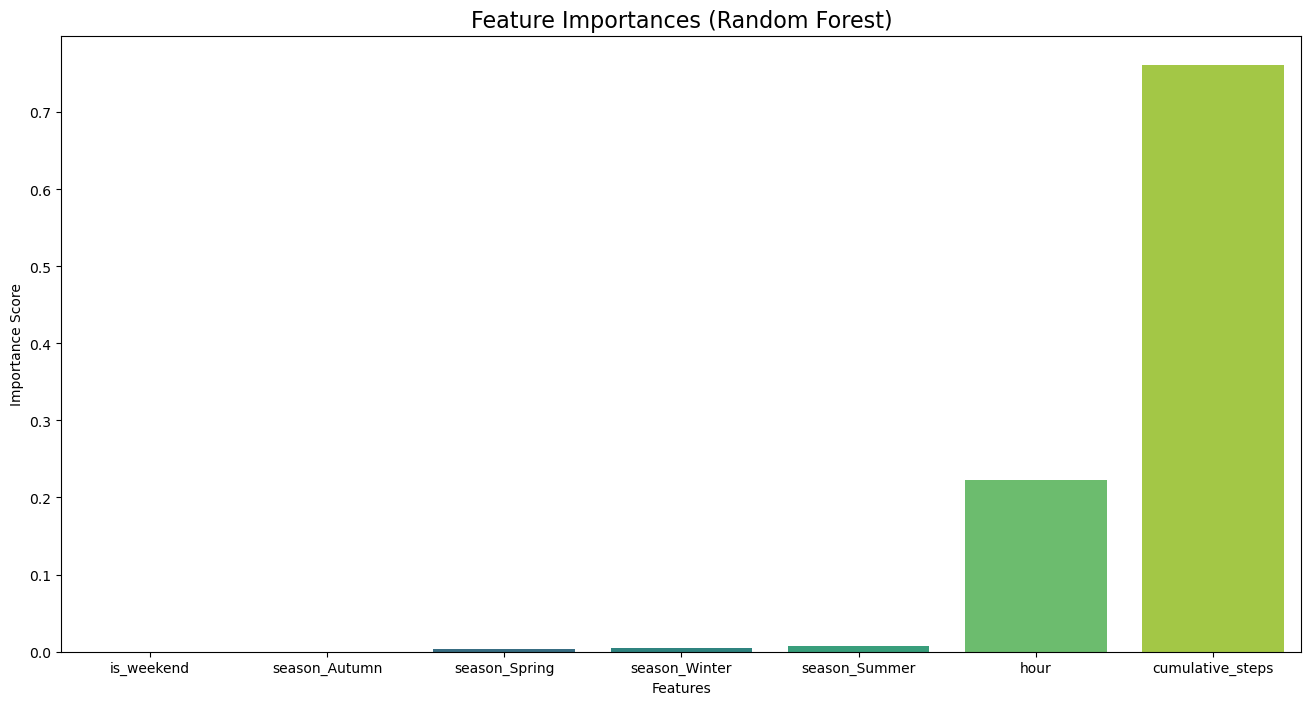

In [707]:
# Récupération et affichage textuel
feature_importances = model.feature_importances_
features = X_train.columns
sorted_idx = feature_importances.argsort()

num_features = len(features)
top_n = min(10, num_features)

print("\n" + "="*50)
print(f"IMPORTANCE DES CARACTÉRISTIQUES (Top {top_n})")
print("="*50)
for i in range(1, top_n + 1):
    idx = sorted_idx[-i]
    print(f"{i}. {features[idx]} : {feature_importances[idx]:.4f}")

print("\nAnalyse :")
print(f"Caractéristique la plus importante : {features[sorted_idx[-1]]} ({feature_importances[sorted_idx[-1]]:.4f})")
print(f"Caractéristique la moins importante : {features[sorted_idx[0]]} ({feature_importances[sorted_idx[0]]:.4f})")
print("="*50 + "\n")

# Visualisation finale corrigée
show_plot(
    bar_plot_x=features[sorted_idx],
    bar_plot_y=feature_importances[sorted_idx],
    bar_plot_hue=features[sorted_idx],
    bar_plot_palette='viridis',
    fig_size=(16, 8),  # Largeur augmentée
    title='Feature Importances (Random Forest)',
    x_label='Features',
    y_label='Importance Score',
    x_ticks_rotation=25,  # Rotation réduite
    tight_layout=None,  # Désactivé et remplacé par un ajustement manuel
    bar_plot_legend=False
)

In [708]:
# Calcul des métriques supplémentaires
tn, fp, fn, tp = cm.ravel()
precision_0 = tn / (tn + fn)
recall_0 = tn / (tn + fp)

print("\nMÉTRIQUES PAR CLASSE :")
print(f"Classe 0 - Précision : {precision_0:.2%} | Rappel : {recall_0:.2%}")
print(f"Classe 1 - Précision : {report['1']['precision']:.2%} | Rappel : {report['1']['recall']:.2%}")
print("\nBILAN :")
print(f"Faux positifs/day (si données quotidiennes) : {fp/30:.1f}/jour")
print(f"Faux négatifs/day : {fn/30:.1f}/jour")


MÉTRIQUES PAR CLASSE :
Classe 0 - Précision : 98.88% | Rappel : 96.95%
Classe 1 - Précision : 92.61% | Rappel : 97.21%

BILAN :
Faux positifs/day (si données quotidiennes) : 436.3/jour
Faux négatifs/day : 156.9/jour


In [709]:
# 8. Fonction de prédiction
def predict_for_user():
    print("\nPredict whether you will reach your daily step goal:")

    try:
        # Saisie utilisateur
        current_date = input("\nEnter current date (YYYY-MM-DD): ")
        current_time = input("Enter current time (HH:MM): ")
        current_steps = float(input("Current cumulative steps: "))

        # Validation des entrées
        hour = int(current_time.split(':')[0])
        if hour < 0 or hour > 23:
            raise ValueError("Hour must be between 0 and 23")
        if current_steps < 0:
            raise ValueError("Steps must be positive")

        # Calcul des features
        date_obj = pd.to_datetime(current_date)
        season = get_season(date_obj)
        is_weekend = date_obj.weekday() >= 5

        # Préparation des données
        user_data = pd.DataFrame({
            'hour': [hour],
            'is_weekend': [int(is_weekend)],
            'cumulative_steps': [current_steps],
            'season_Spring': [1 if season == 'Spring' else 0],
            'season_Summer': [1 if season == 'Summer' else 0],
            'season_Autumn': [1 if season == 'Autumn' else 0],
            'season_Winter': [1 if season == 'Winter' else 0]
        })

        # Prédiction avec lissage des probabilités
        proba = model.predict_proba(user_data[features])[0][1]

        # Transformation logit pour éviter les 0% et 100%
        proba = max(0.01, min(0.99, proba))  # Borné entre 1% et 99%

        daily_goal = overall_avg_steps * 60 * 24

        # Ajustement basé sur la progression
        progress_ratio = current_steps / daily_goal
        time_ratio = hour / 18  # Ratio de la journée écoulée

        # Formule d'ajustement (peut être fine-tunée)
        adjusted_proba = proba * (1 + (progress_ratio - time_ratio))
        adjusted_proba = max(0.01, min(0.99, adjusted_proba))

        # Seuil dynamique
        prediction_threshold = 0.5 - (0.3 * (1 - time_ratio))
        prediction = adjusted_proba >= prediction_threshold

        # Affichage
        print(f"\nPrediction for {current_date} at {current_time}:")
        print(f"- Current: {current_steps:.0f}/{daily_goal:.0f} ({progress_ratio:.1%})")
        print(f"- Time elapsed: {time_ratio:.1%} of day")
        print(f"- Prediction: {'WILL REACH' if prediction else 'WILL NOT REACH'}")
        print(f"- Confidence: {adjusted_proba:.1%} (adjusted)")

        # Recommandations
        if hour < 18:
            remaining_hours = 18 - hour
            needed_steps = max(daily_goal - current_steps, 0)
            if remaining_hours > 0:
                hourly_pace = needed_steps / remaining_hours
                print(f"\nTo reach your goal by 18:00:")
                print(f"- Needed: {needed_steps:.0f} more steps")
                print(f"- Required pace: {hourly_pace:.0f} steps/hour")

                if hourly_pace > 1500:
                    print("- Activity suggestion: Vigorous walk + jogging")
                elif hourly_pace > 1000:
                    print("- Activity suggestion: Brisk walking")
                else:
                    print("- Activity suggestion: Leisurely walking")

    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Please try again with valid inputs.")

In [710]:
# 9. Exemple d'utilisation
print("\nStep Goal Prediction System")
print("---------------------------")
print(f"Based on average goal: {overall_avg_steps * 60 * 24:.0f} steps per day")
predict_for_user()


Step Goal Prediction System
---------------------------
Based on average goal: 8307 steps per day

Predict whether you will reach your daily step goal:

Error: could not convert string to float: ''
Please try again with valid inputs.
